### Chapter 15
**CH15A Used cars with regression trees**

using the used-cars dataset

version 1.0 2024-01-01

#### Prerequisites

In order to be able to display tree objects you need to get `Graphviz` installed on your computer. 
- Installation instructions for Windows can be found [here](https://forum.graphviz.org/t/new-simplified-installation-procedure-on-windows/224). Make soure you choose the `Add Graphviz to the system PATH for current user` option.
- More on `Graphviz` [here](https://graphviz.org/about/)

Once you installed `Graphviz` you need to restart your computer.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import random
from mizani.formatters import percent_format
import os
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse
from patsy import dmatrices

from sklearn.metrics import r2_score,mean_squared_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import DecisionTreeRegressor
from collections import Counter
from io import StringIO
from IPython.display import Image, display
import pydotplus
import graphviz

### Get Data

In [2]:
# Current script and repository folder
current_path = os.getcwd()
repository_path = current_path.split('Ch15')[0]

In [3]:
# Add utils folder to sys path 
# Note: os.path.join() creates a string with the right syntax for defining a path for your operating sytem.
sys.path.append(os.path.join(repository_path, 'utils'))

In [4]:
# Define data folder
data_path = os.path.join(repository_path, 'data')

In [5]:
# Import the prewritten helper functions
from py_helper_functions import *

In [6]:
# DATA IMPORT
data = pd.read_csv(os.path.join(data_path, 'used-cars_2cities_prep.csv'))

### EDA & feature engineering

**Filtering**

In [7]:
# Manage missing
data["fuel"] = data["fuel"].fillna("Missing")
data["drive"] = data["drive"].fillna("Missing")
data["cylinders"] = data["cylinders"].fillna("Missing")
data["transmission"] = data["transmission"].fillna("Missing")
data["type"] = data["type"].fillna("Missing")

In [8]:
data['condition'].value_counts()

condition
excellent    139
good         114
like new      55
fair          15
new            4
Name: count, dtype: int64

In [9]:
data["condition"] = data["condition"].fillna("good")

In [10]:
data['condition'].value_counts()

condition
good         336
excellent    139
like new      55
fair          15
new            4
Name: count, dtype: int64

In [11]:
# drop hybrid models then drop column
data = (data.query("Hybrid==0")).drop(["Hybrid"], axis=1)

# keep gas-fuelled vehicles
data = data.query("fuel=='gas'")
    # alternative: data = data[data.fuel == 'gas']]

# drop vehicles in fair and new condition, trucks
data = data.query("condition not in ['new','fair']")
    # alternative: data = data[~data.condition.isin(['new','fair'])]

# drop unrealistic values for price and odometer reading
data = data.query("price in @seq(500,25001,by=1)").query("odometer<=100")

# drop if price is smaller than 1000 and condition is like new or age is less than 8
data = data.query("~(price < 1000 & (condition == 'like new'|age < 8))")

data = data.query("~(transmission=='manual')")

# drop if truck
data = data.query("type not in ['truck','pickup']")

# drop pricestr
data = data.drop(["pricestr"], axis=1)

In [12]:
# to be on the safe side
data = data[data["price"].notna()]
data.reset_index(drop = True, inplace = True )

In [13]:
data.shape

(477, 21)

**Additional variables**

In [14]:
# condition
data["cond_excellent"] = np.where(data["condition"] == "excellent", 1, 0)
data["cond_good"] = np.where(data["condition"] == "good", 1, 0)
data["cond_likenew"] = np.where(data["condition"] == "like new", 1, 0)
# cylinders
data["cylind6"] = np.where(data["cylinders"] == "6 cylinders", 1, 0)
data.cylinders.value_counts()
data.cylind6.value_counts()
#chicago
data["chicago"] = np.where(data["area"] == "chicago", 1, 0)
# age: quadratic, cubic
data["agesq"] = data["age"] ** 2
data["agecu"] = data["age"] ** 3
# odometer quadratic
data["odometersq"] = data["odometer"] ** 3

In [15]:
data.price.describe()

count      477.000000
mean      5843.878407
std       4334.571604
min        500.000000
25%       2500.000000
50%       4400.000000
75%       8300.000000
max      18500.000000
Name: price, dtype: float64

In [16]:
smp_size=np.floor(0.7*data.shape[0])
smp_size

333.0

In [17]:
# Initialize random seed to make it reproducible
random.seed(20240122)
train_ids = random.sample(range(0, data.shape[0]), int(smp_size))
train_ids[:10]

[432, 77, 200, 229, 127, 270, 325, 141, 192, 171]

In [18]:
data["train"] = 0
data["train"][train_ids] = 1

In [19]:
data["train"].value_counts()

train
1    333
0    144
Name: count, dtype: int64

In [20]:
data_train = data.query('train==1')
data_test = data.query('train==0')

### CART using 'age' as a single predictor variable

#### A single split

In [21]:
data_train.price.describe()

count      333.000000
mean      5777.783784
std       4425.314206
min        500.000000
25%       2500.000000
50%       3980.000000
75%       8300.000000
max      18500.000000
Name: price, dtype: float64

In [22]:
cart1 = DecisionTreeRegressor(random_state = 20240122, max_depth = 1)

# Note X should be a matrix instead of series, that's why we need double []
X = data_train[['age']]
Y = data_train['price']
cart1.fit(X,Y)

DecisionTreeRegressor(max_depth=1, random_state=20240122)

In [23]:
pred_cart1 = cart1.predict(data_test[["age"]])

rmse_cart1 = np.sqrt(mean_squared_error(data_test["price"], pred_cart1))

#### Plotting a regression tree: a deep dive into some Python specifics

At the core lies `Graphviz`, an open source [graph visualization software](https://www.graphviz.org/about/). Graphviz uses the [DOT Language](https://www.graphviz.org/doc/info/lang.html) an abstract grammar for defining Graphviz nodes, edges, graphs, subgraphs, and clusters.

Modules used below: 
- Python `StringIO` module is an in-memory file-like object which can be used as both input and output to most of the functions expecting a standard file object. In other words, the file-like object acts like a regular file allowing most of the standard file I/O operations. 
One of the important differences between them is that regular files are visible to the OS whereas file objects are created in memory and hence can be handled more efficientl
- `sklearn.tree.export_graphviz`: Export a decision tree in DOT format. 
This function generates a GraphViz representation of the decision tree, which is then written int*o out_fi*le. Once exported, graphical renderings can be generat.
- `pydotplus`:  provides a [Python Interface](https://pydotplus.readthedocs.io/index.html) to Graphviz’s Dot language.ed

**There are two ways to display tree graphs**:
1. Writing the .dot file to the local filesystem, then reading and displaying it using the `graphviz` module.

In [24]:
export_graphviz(cart1, 'tree.dot', filled=True, rounded=True, special_characters=True, feature_names=["age"])

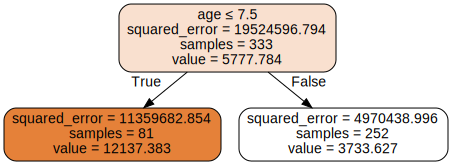

In [25]:
with open('tree.dot', 'r') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

2. Through a `StringIO` object using `pydotplus`.

*How does it work?*

In [26]:
dt = StringIO()

In [27]:
export_graphviz(cart1, dt, filled=True, rounded=True, special_characters=True, feature_names=["age"])

In [28]:
print(dt.getvalue())

digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label=<age &le; 7.5<br/>squared_error = 19524596.794<br/>samples = 333<br/>value = 5777.784>, fillcolor="#f9e0cf"] ;
1 [label=<squared_error = 11359682.854<br/>samples = 81<br/>value = 12137.383>, fillcolor="#e58139"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label=<squared_error = 4970438.996<br/>samples = 252<br/>value = 3733.627>, fillcolor="#ffffff"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
}


In [29]:
g = pydotplus.graph_from_dot_data(dt.getvalue())
type(g)

pydotplus.graphviz.Dot

*Putting it all together*

In [30]:
def jupyter_graphviz(m, **kwargs):
    dot_data = StringIO()
    export_graphviz(m, dot_data, **kwargs)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    display(Image(graph.create_png()))

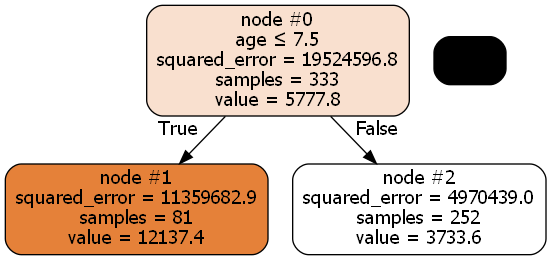

In [31]:
jupyter_graphviz(
    cart1, filled=True, rounded=True, special_characters=True, feature_names=["age"], node_ids = True, precision = 1, fontname = 'sans'
)

3. Using `sklearn.tree.plot_tree`

In [32]:
from sklearn import tree

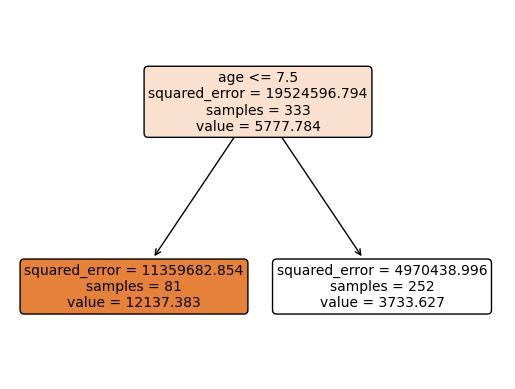

In [33]:
tree.plot_tree(cart1, filled = True, rounded = True, feature_names=["age"], fontsize = 10);

In [34]:
### Scatterplot with step function
plot_helper = list(range(data_train['age'].min(), data_train['age'].max()))

In [35]:
df_plot_helper = pd.DataFrame({"age":plot_helper})
df_plot_helper['xend'] = pd.Series(plot_helper)+1
df_plot_helper['yend'] = cart1.predict(df_plot_helper[['age']])
pred_cart1t = cart1.predict(data_train[['age']])

In [36]:
df_plot_helper

age  xend          yend
0     1     2  12137.382716
1     2     3  12137.382716
2     3     4  12137.382716
3     4     5  12137.382716
4     5     6  12137.382716
5     6     7  12137.382716
6     7     8  12137.382716
7     8     9   3733.626984
8     9    10   3733.626984
9    10    11   3733.626984
10   11    12   3733.626984
11   12    13   3733.626984
12   13    14   3733.626984
13   14    15   3733.626984
14   15    16   3733.626984
15   16    17   3733.626984
16   17    18   3733.626984
17   18    19   3733.626984
18   19    20   3733.626984
19   20    21   3733.626984
20   21    22   3733.626984
21   22    23   3733.626984
22   23    24   3733.626984
23   24    25   3733.626984
24   25    26   3733.626984
25   26    27   3733.626984

**ggplot**

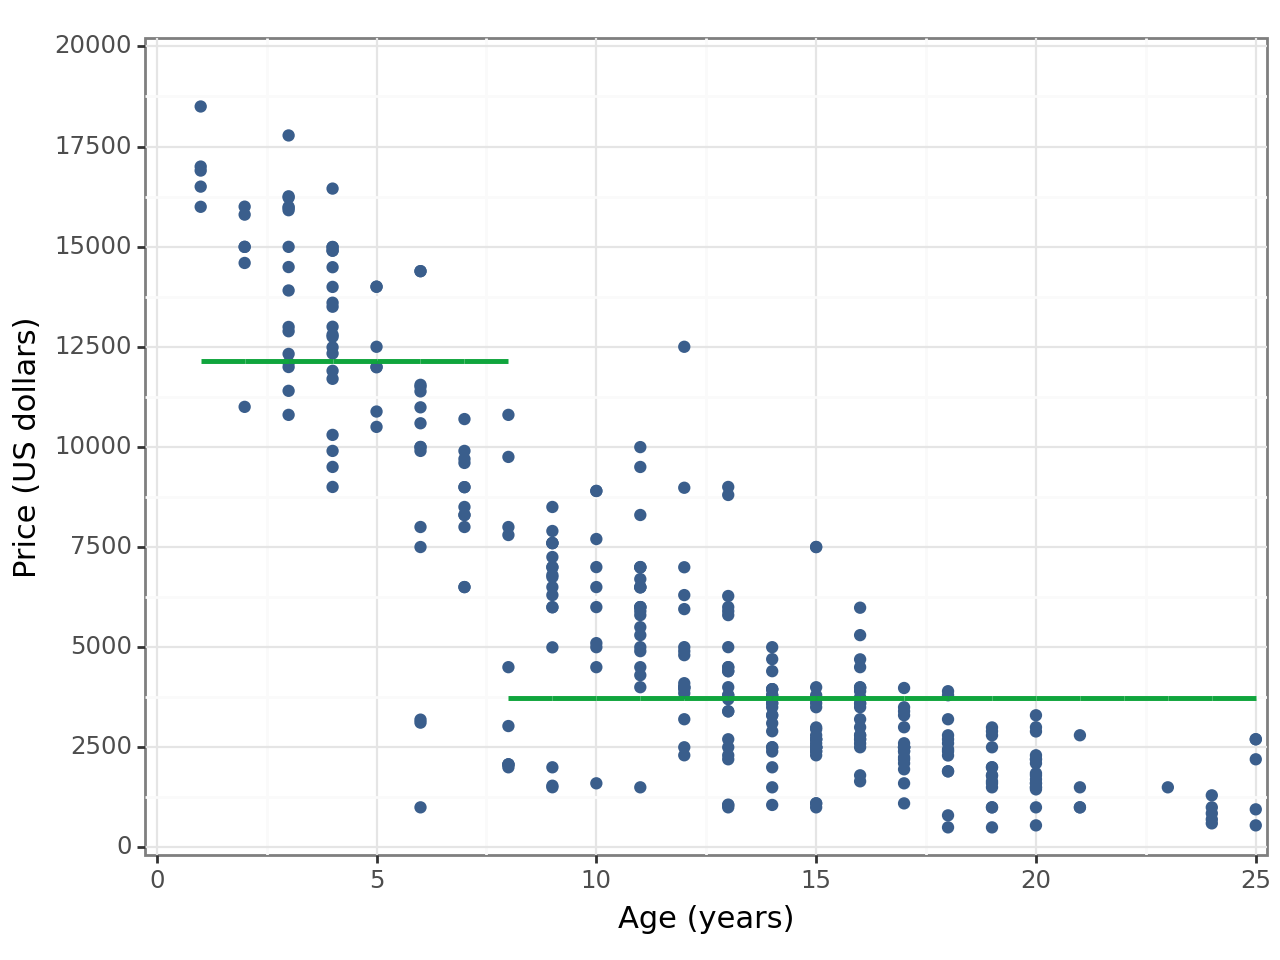

<Figure Size: (640 x 480)>

In [37]:
ggplot(data_train, aes(x="age", y="price")) + geom_point(color=color[0]) + geom_segment(
    df_plot_helper,
    aes(x="age", y="yend", xend="xend", yend="yend"),
    color=color[1],
    size=1,
    na_rm=True,
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20001, by=2500)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 25), breaks=seq(0, 26, by=5)
) + labs(
    x="Age (years)", y="Price (US dollars)"
) + theme_bw()

**matplotlib** (a little more tedious)

In [38]:
cart1.tree_.threshold

array([ 7.5, -2. , -2. ])

In [39]:
cart1_cuts = cart1.tree_.threshold[cart1.tree_.threshold != -2]
cart1_cuts

array([7.5])

In [40]:
df_plot = data_train
df_plot['predicted_price'] = pred_cart1t
df_plot.sort_values(by = 'age', inplace = True)

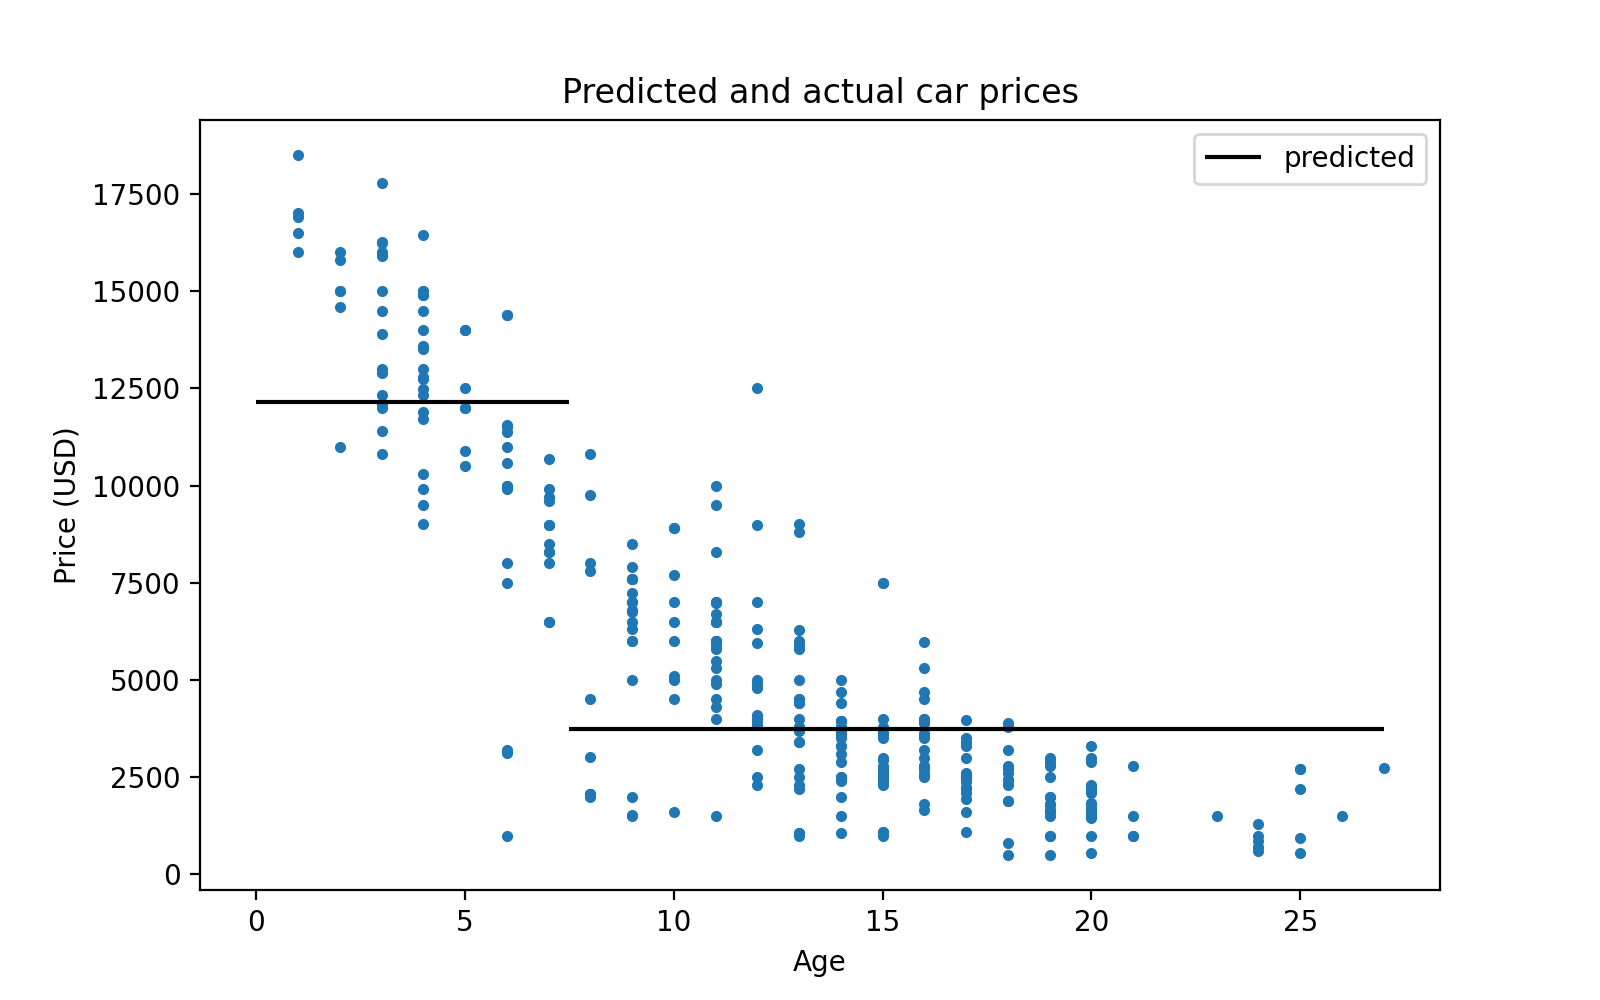

In [41]:
plt.figure(figsize = (8,5))
plt.scatter(x = df_plot.age, y = df_plot.price, marker = '.')
plt.hlines(df_plot.predicted_price.max(), 0, cart1_cuts, color = 'k')
plt.hlines(df_plot.predicted_price.min(), cart1_cuts, df_plot.age.max(), color = 'k', label = 'predicted')
plt.legend()
plt.ylabel('Price (USD)')
plt.xlabel('Age')
plt.title('Predicted and actual car prices')
plt.show();

In [42]:
# {:0,.0f}
[f'${x:0,.0f}' for x in range(0, 20000, 2500)]

['$0',
 '$2,500',
 '$5,000',
 '$7,500',
 '$10,000',
 '$12,500',
 '$15,000',
 '$17,500']

### Splits at two levels (setting "max_depth" to 2)

In [43]:
cart2 = DecisionTreeRegressor(random_state=20240122, max_depth=2)
# Note X should be a matrix instead of series, that's why we need double []
X = data_train[["age"]]
Y = data_train["price"]
cart2.fit(X, Y)

DecisionTreeRegressor(max_depth=2, random_state=20240122)

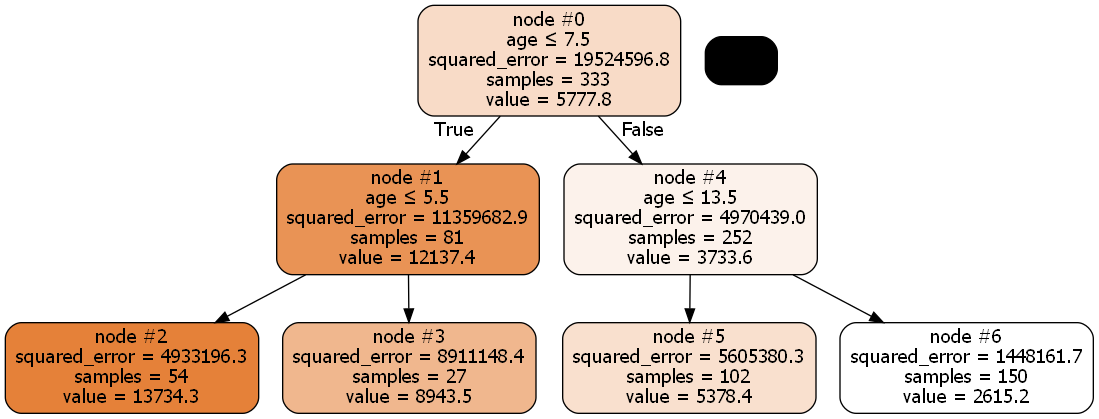

In [44]:
jupyter_graphviz(
    cart2, filled=True, rounded=True, special_characters=True, feature_names=["age"], node_ids = True, precision = 1, fontname = 'sans'
)

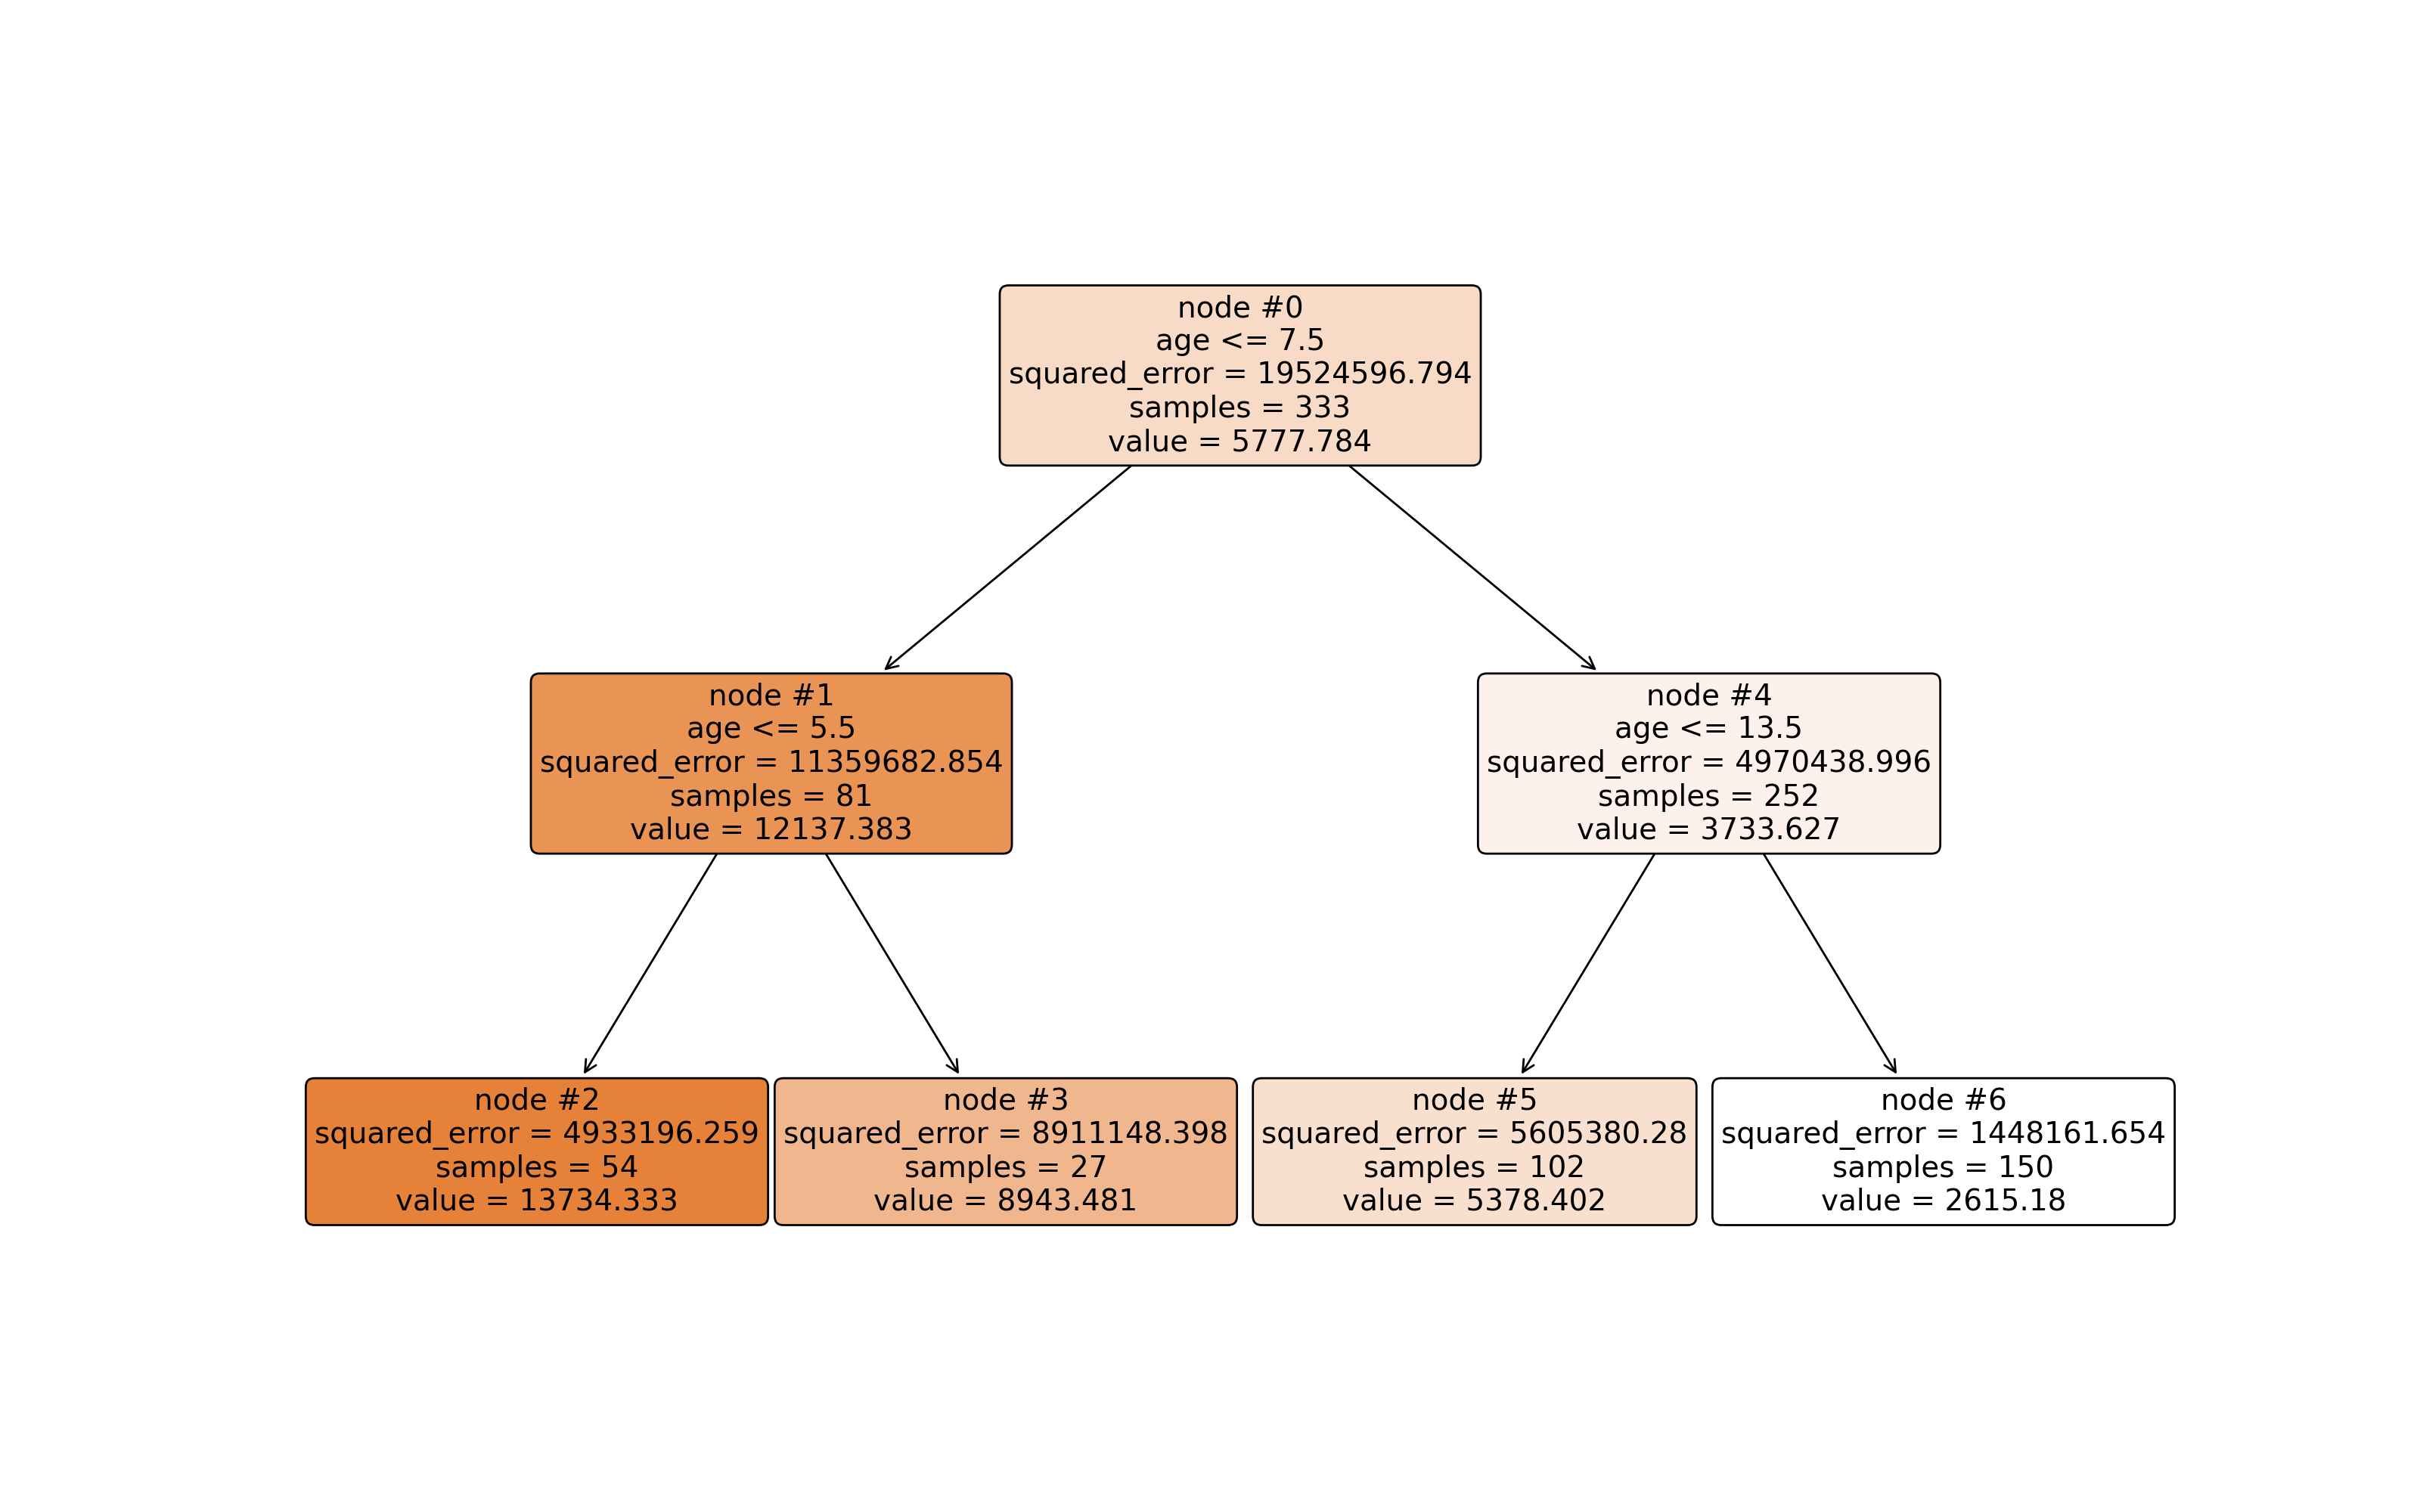

In [45]:
plt.figure(figsize = (16,10))
tree.plot_tree(cart2, filled = True, rounded = True, feature_names=["age"], fontsize = 14, node_ids = True);

In [46]:
# Cut points
cuts = cart2.tree_.threshold[cart2.tree_.threshold != -2]
cuts

array([ 7.5,  5.5, 13.5])

In [47]:
# Groups
groups = [0]
for x in cuts:
    groups += [int(np.floor(x)), int(np.floor(x) + 1)]
    
groups = sorted(groups) + ["or more"]
groups

[0, 5, 6, 7, 8, 13, 14, 'or more']

In [48]:
# get the leaf for each training sample
leaves_index = cart2.apply(X)
leaves_index # => these are all terminal leaves only!

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,

In [49]:
# use Counter to find the number of elements on each leaf
cnt = Counter(sorted(leaves_index))
cnt

Counter({2: 54, 3: 27, 5: 102, 6: 150})

In [50]:
# and now you can index each input to get the number of elements
elems = [cnt[x] for x in leaves_index]
print(elems[:10], '\t', elems[-10:])

[54, 54, 54, 54, 54, 54, 54, 54, 54, 54] 	 [150, 150, 150, 150, 150, 150, 150, 150, 150, 150]


In [51]:
counts=list(cnt.values())
counts

[54, 27, 102, 150]

In [52]:
av_price = (
    pd.DataFrame({"index": leaves_index, "fit": cart2.predict(X)})
    .drop_duplicates()
    .sort_values("index")["fit"]
    .tolist()
)
av_price

[13734.333333333334, 8943.481481481482, 5378.401960784314, 2615.18]

In [53]:
pd.DataFrame(
    {
        "Category": [
            y
            for x, y in enumerate(
                [
                    "Age " + str(groups[i]) + "-" + str(groups[i + 1])
                    for i in range(len(groups) - 1)
                ]
            )
            if x % 2 == 0
        ],
        "Count": counts,
        "Average_price": av_price,
    }
)

Category  Count  Average_price
0         Age 0-5     54   13734.333333
1         Age 6-7     27    8943.481481
2        Age 8-13    102    5378.401961
3  Age 14-or more    150    2615.180000

In [54]:
data_train[(data_train.age>1)&(data_train.age<12)].shape

(137, 31)

In [55]:
pred_cart2 = cart2.predict(data_test[["age"]])

rmse_cart2 = np.sqrt(mean_squared_error(data_test["price"], pred_cart2))

In [56]:
### Scatterplot with step function
plot_helper = list(range(data_train['age'].min(), data_train['age'].max()))

df_plot_helper = pd.DataFrame({"age": plot_helper})
df_plot_helper["xend"] = pd.Series(plot_helper) + 1
df_plot_helper["yend"] = cart2.predict(df_plot_helper[["age"]])
pred_cart1t = cart2.predict(data_train[["age"]])

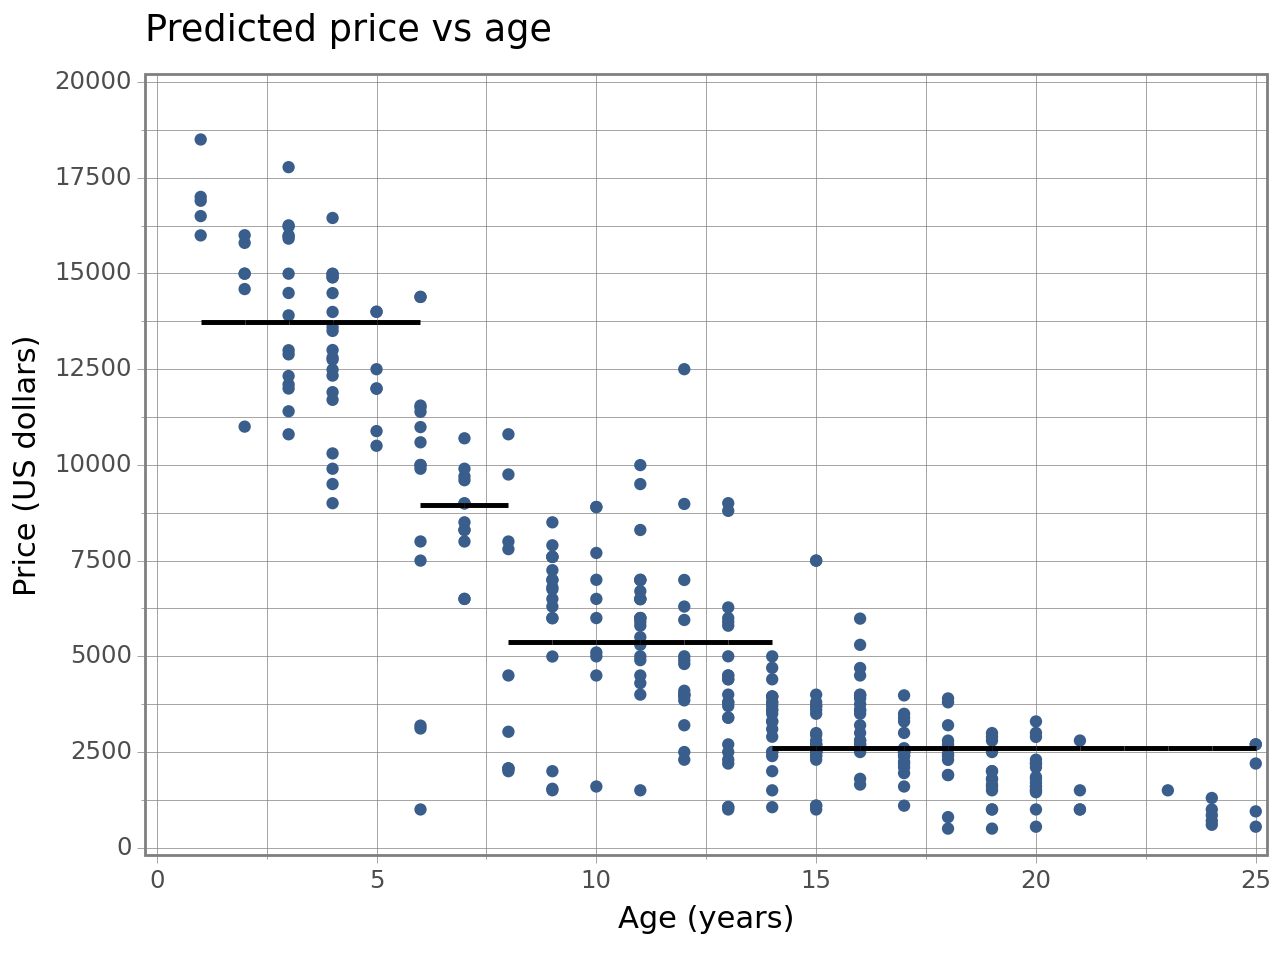

<Figure Size: (640 x 480)>

In [57]:
ggplot(data_train, aes(x="age", y="price")) + geom_point(color=color[0]) + geom_segment(
    df_plot_helper,
    aes(x="age", y="yend", xend="xend", yend="yend"),
    color='k',
    size=1,
    na_rm=True,
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20001, by=2500)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 25), breaks=seq(0, 26, by=5)
) + labs(
    x="Age (years)", y="Price (US dollars)", title = "Predicted price vs age"
) + theme_bw(
) + theme(line = element_line(color = "grey", size = 0.25))


#### Splitting using the *complexity parameter*

**Note**: 
- `min_impurity_decrease` in sklearn is considered to be the same as complexity parameter; the actual values are different but the purpose is the same
- `squared error` as *criterion* (measuring the quality of the split) stands for `mean squared error`. There is no metric targeting $R^2$.

In [58]:
cart3 = DecisionTreeRegressor(
    random_state=20240122, criterion="squared_error", min_impurity_decrease=50000
)
# Note X should be a matrix instead of series, that's why we need double []
X = data_train[["age"]]
Y = data_train["price"]
cart3.fit(X, Y)

DecisionTreeRegressor(min_impurity_decrease=50000, random_state=20240122)

In [59]:
pred_cart3 = cart3.predict(data_test[["age"]])

rmse_cart3 = np.sqrt(mean_squared_error(data_test["price"], pred_cart3))
rmse_cart3

1764.6240311410868

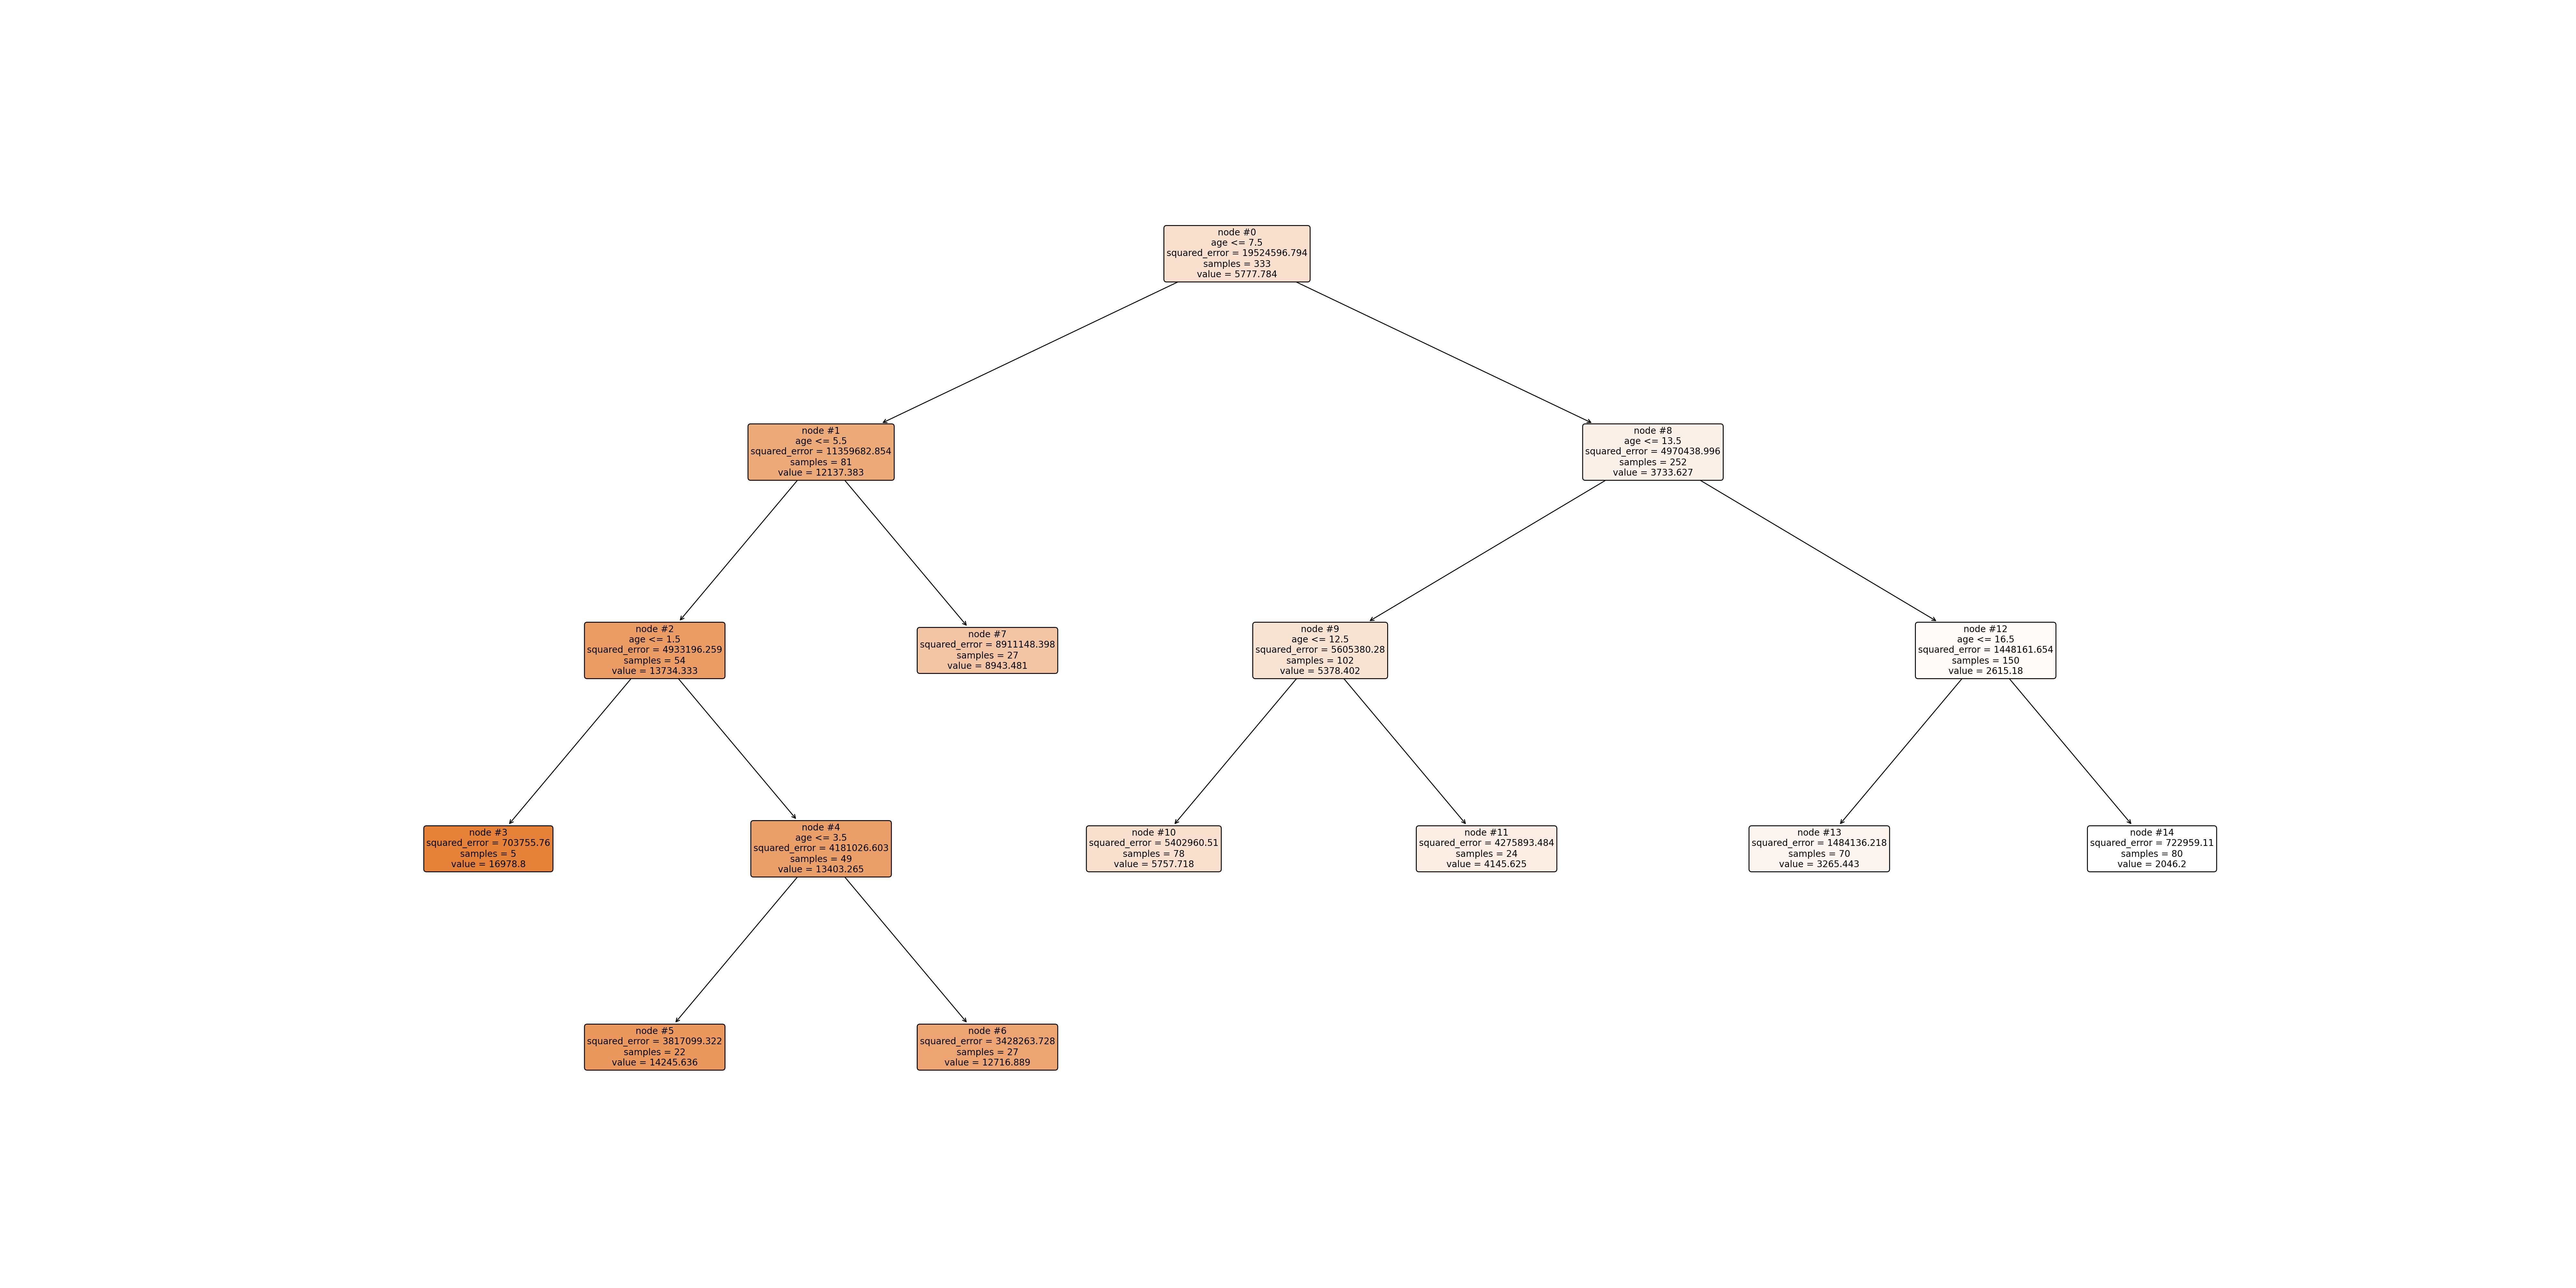

In [60]:
plt.figure(figsize = (40,20))
tree.plot_tree(cart3, filled = True, rounded = True, feature_names=["age"], fontsize = 10, node_ids = True);

In [61]:
### Scatterplot with step function
plot_helper = list(range(data_train['age'].min(), data_train['age'].max()))

df_plot_helper = pd.DataFrame({"age": plot_helper})
df_plot_helper["xend"] = pd.Series(plot_helper) + 1
df_plot_helper["yend"] = cart3.predict(df_plot_helper[["age"]])
pred_cart3t = cart3.predict(data_train[["age"]])

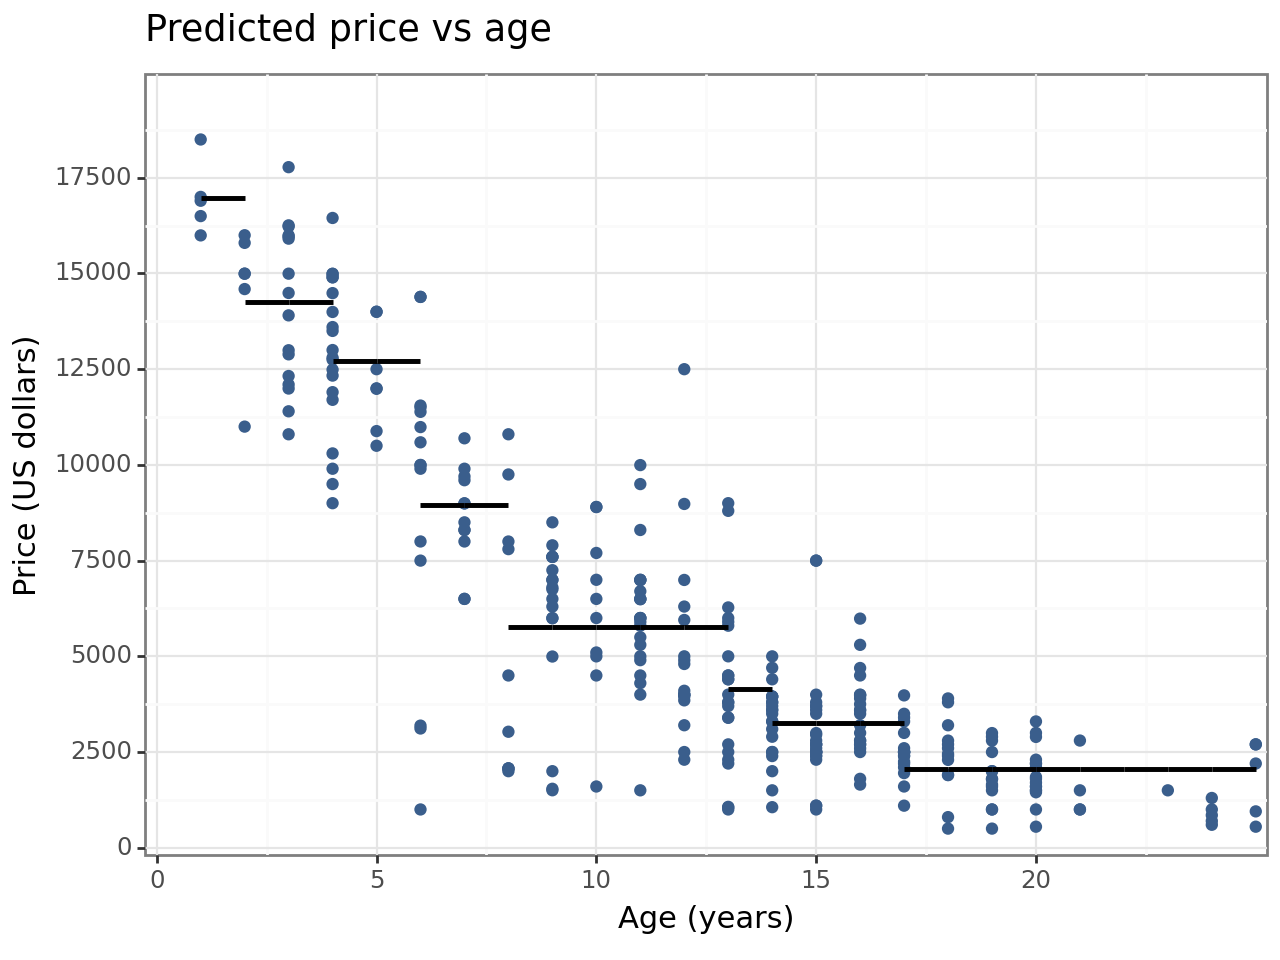

<Figure Size: (640 x 480)>

In [62]:
ggplot(data_train, aes(x="age", y="price")) + geom_point(color=color[0]) + geom_segment(
    df_plot_helper,
    aes(x="age", y="yend", xend="xend", yend="yend"),
    color='k',
    size=1,
    na_rm=True,
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20000, by=2500)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 25), breaks=seq(0, 25, by=5)
) + labs(
    x="Age (years)", y="Price (US dollars)", title = "Predicted price vs age"
) + theme_bw()



#### Age only linear regression
---

In [63]:
linreg1=smf.ols("price~age",data=data_train).fit()
print(linreg1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     808.8
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           6.97e-91
Time:                        10:50:24   Log-Likelihood:                -3061.7
No. Observations:                 333   AIC:                             6127.
Df Residuals:                     331   BIC:                             6135.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.366e+04    306.415     44.570      0.0

In [64]:
pred_linreg1 = linreg1.predict(data_test)
rmse_ols1 = np.sqrt(mean_squared_error(data_test["price"], pred_linreg1))
rmse_ols1

2060.6811378639836

In [65]:
## Scatterplot with predicted values
pred_linreg1t=linreg1.predict(data_train)

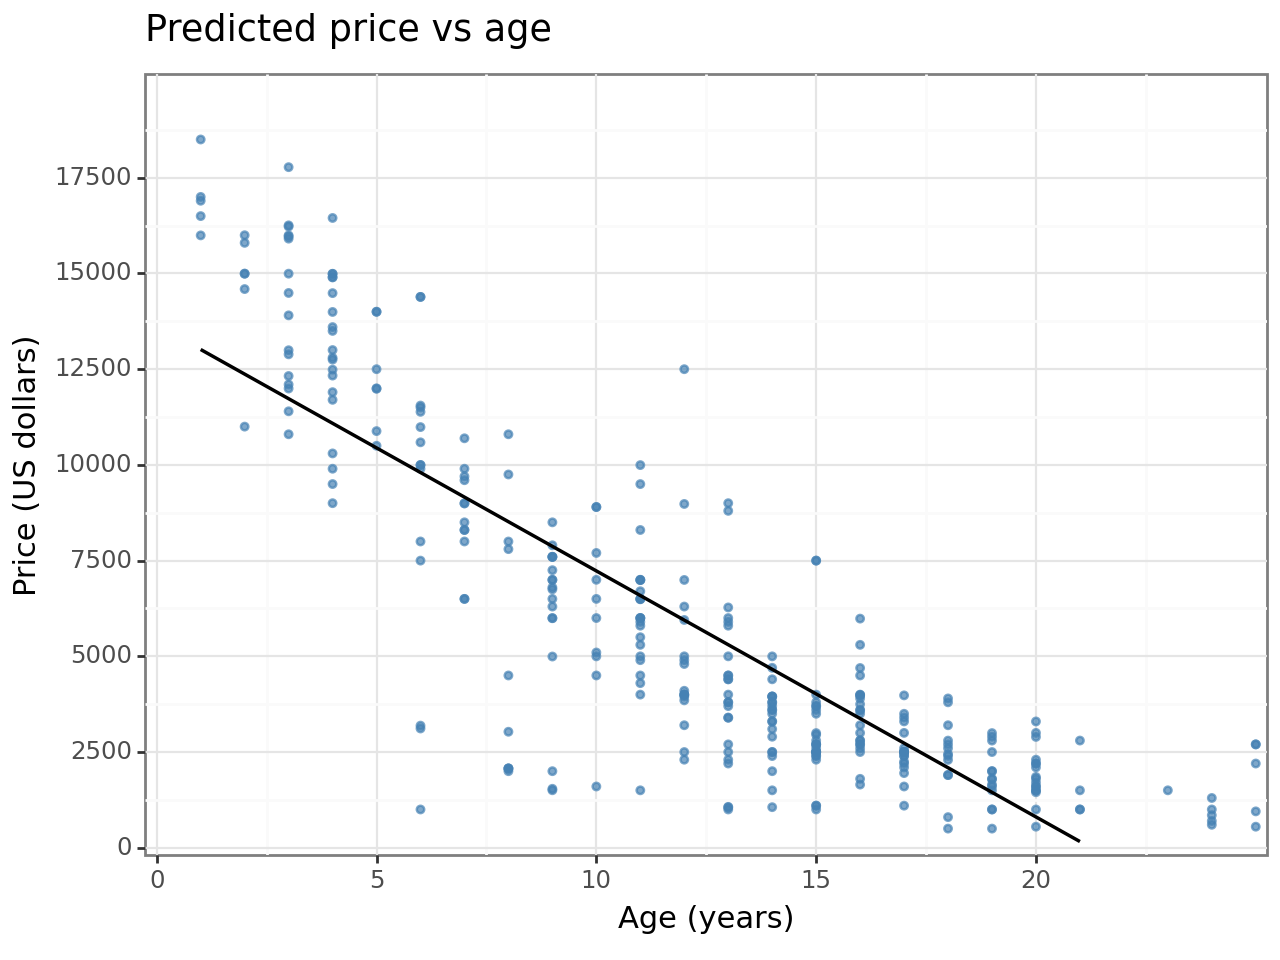

<Figure Size: (640 x 480)>

In [66]:
ggplot(data_train) + geom_point(
    aes(x="age", y="price"),
    color='steelblue',
    size=1,
    alpha=0.7,
    show_legend=False,
    na_rm=True,
) + geom_line(
    aes(x="age", y="pred_linreg1t"), colour='k', size=0.7
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(0, 20000), breaks=seq(0, 20000, by=2500)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 25), breaks=seq(0, 25, by=5)
) + labs(
    x="Age (years)", y="Price (US dollars)", title = "Predicted price vs age"
) + theme_bw()

#### Loess using `ggplot` and `statsmodels`

`statdmodels` provides various [non-parametric methods](https://www.statsmodels.org/stable/nonparametric.html#module-statsmodels.nonparametric) from which `KernelReg` produces similar results as the `plotnine` backend.

In [67]:
#### Age only only lowess
lowess = sm.nonparametric.KernelReg
# lowess = sm.nonparametric.lowess

In [68]:
lowess1=lowess(data_train.price,data_train.age,"c")
#lowess1=lowess(data_train.price,data_train.age)

In [69]:
pred_lowess1 = lowess1.fit(data_test["age"])
rmse_lowess1 = np.sqrt(mean_squared_error(data_test["price"], pred_lowess1[0]))
pred_lowess1t = lowess1.fit(data_train["age"])

In [70]:
data_lowess = data_train.copy()
data_lowess["pred_lowess1t"] = pred_lowess1t[0]

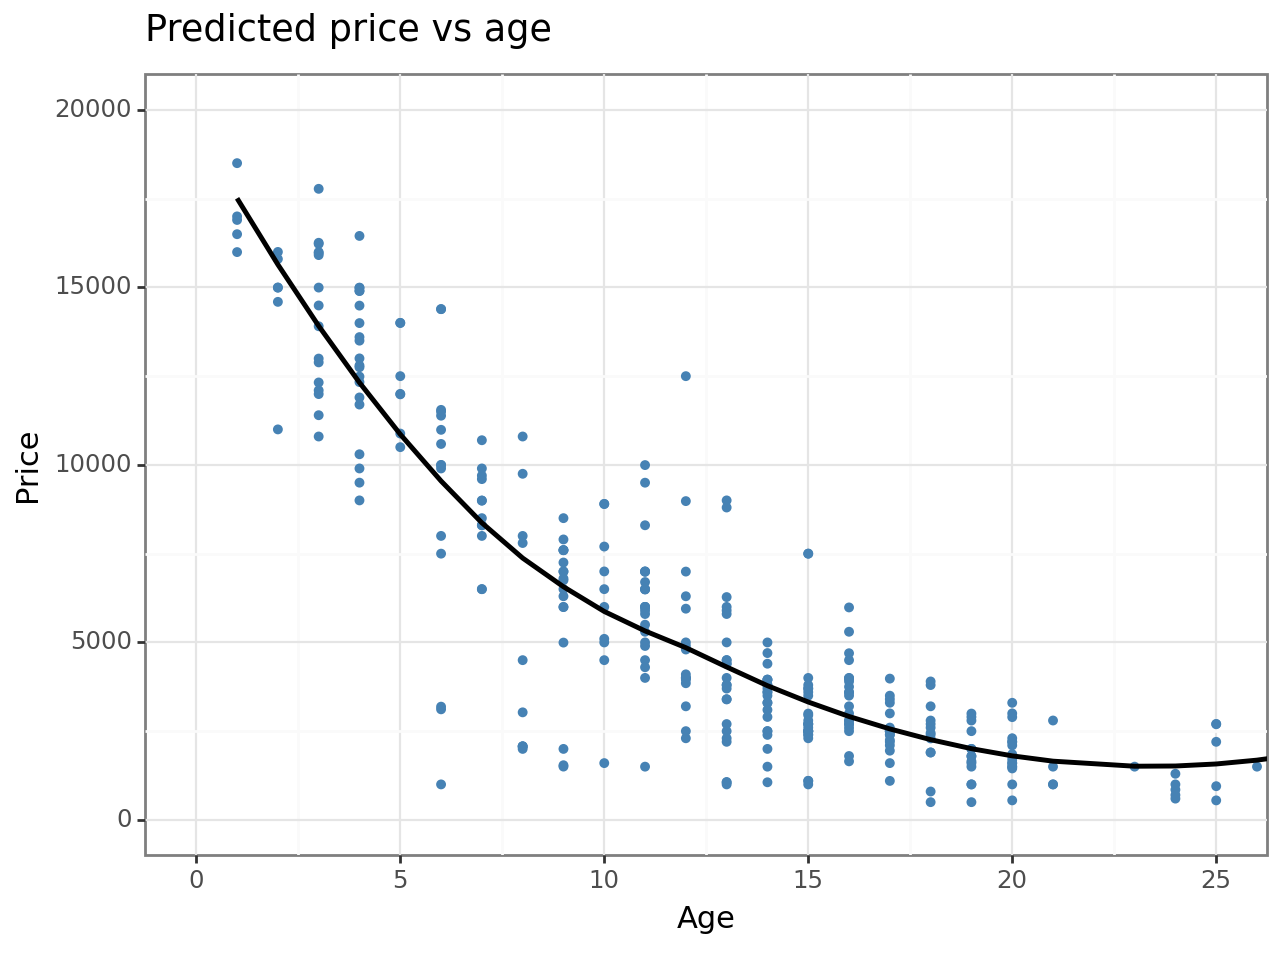

<Figure Size: (640 x 480)>

In [71]:
ggplot(data_train, aes(x="age", y="price")) + geom_point(size=1, colour="steelblue") + labs(
    x="Age", y="Price" , title = "Predicted price vs age"
) + coord_cartesian(xlim=(0, 25), ylim=(0, 20000)) + geom_smooth(
    method="loess", colour="k", se=False, size=1
) + theme_bw()

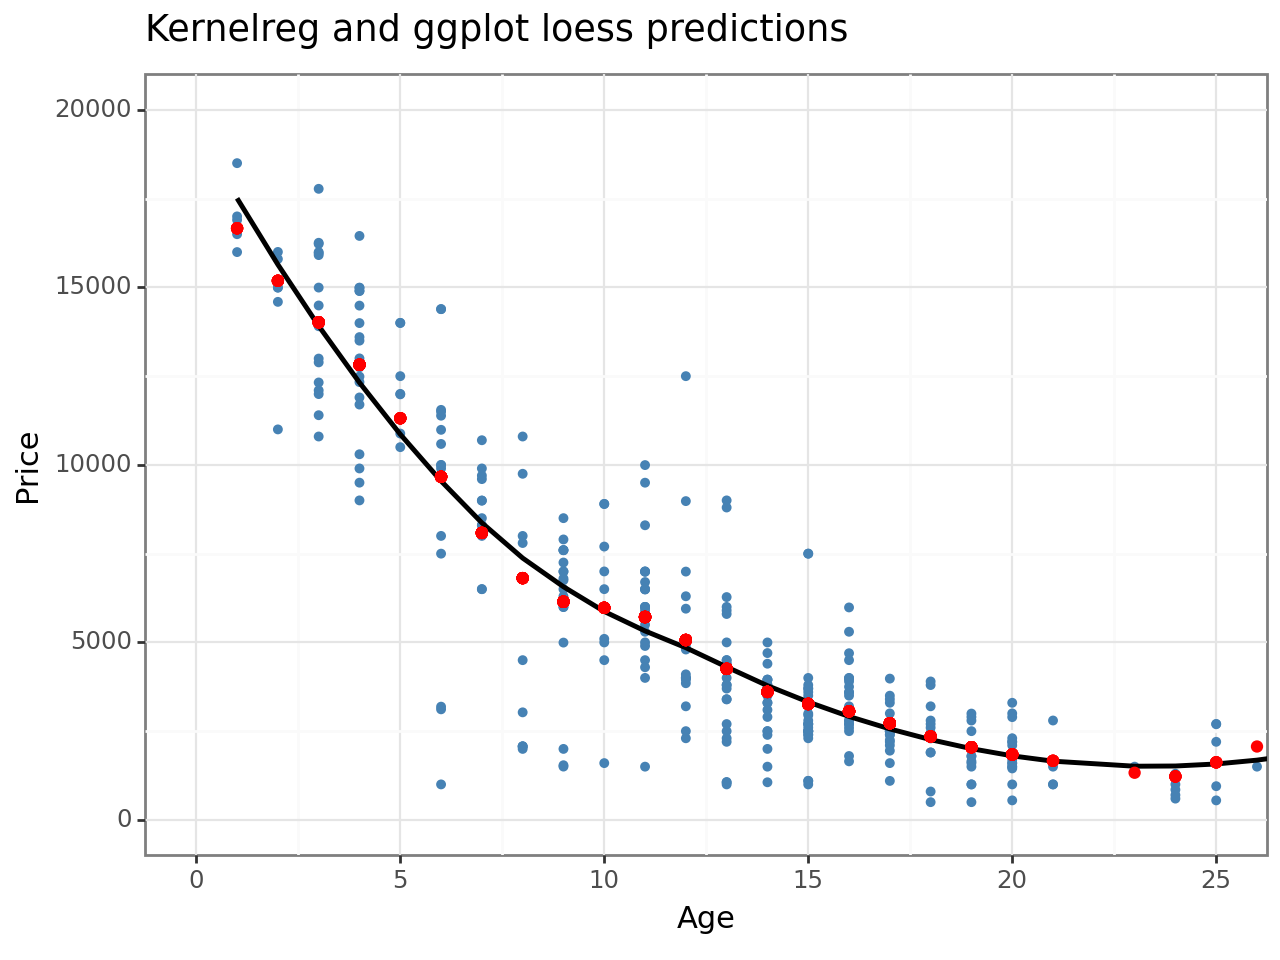

<Figure Size: (640 x 480)>

In [72]:
### Checking kernelreg predictions (red points) - they look the same as loess method results.

(ggplot(data_lowess, aes(x="age", y="price")) + geom_point(
    size=1, colour="steelblue"
) + labs(x="Age", y="Price", title = 'Kernelreg and ggplot loess predictions') + coord_cartesian(
    xlim=(0, 25), ylim=(0, 20000)
) + geom_smooth(
    method="loess", colour="k", se=False, size=1
) + theme_bw() + geom_point(    aes(x="age", y="pred_lowess1t"), color="red")
)

### CART using multiple predictor variables

#### Linear regression baselines

In [73]:
# Linear regression with multiple variables
model2 = "price ~ age + odometer + LE + XLE + SE + cond_excellent + cond_good + cylind6 + dealer + chicago"
linreg2 = smf.ols(model2, data_train).fit()
print(linreg2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     145.1
Date:                Mon, 29 Jan 2024   Prob (F-statistic):          7.16e-113
Time:                        10:50:26   Log-Likelihood:                -2983.6
No. Observations:                 333   AIC:                             5989.
Df Residuals:                     322   BIC:                             6031.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.385e+04    451.620     30.

In [74]:
pred_linreg2 = linreg2.predict(data_test)
rmse_linreg2 = np.sqrt(mean_squared_error(data_test["price"], pred_linreg2))
rmse_linreg2

1803.2501058154257

In [75]:
# add squared for age, odometer
model3 = "price ~ age + agesq+ odometer+odometersq +LE + XLE + SE + cond_excellent + cond_good + cylind6 + dealer+chicago"
linreg3 = smf.ols(model3, data_train).fit()
print(linreg3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     189.6
Date:                Mon, 29 Jan 2024   Prob (F-statistic):          1.84e-137
Time:                        10:50:26   Log-Likelihood:                -2919.1
No. Observations:                 333   AIC:                             5864.
Df Residuals:                     320   BIC:                             5914.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.744e+04    476.790     36.

In [76]:
pred_linreg3 = linreg3.predict(data_test)
rmse_linreg3 = np.sqrt(mean_squared_error(data_test["price"], pred_linreg3))
rmse_linreg3

1451.3489766653788

In [77]:
Y,X = dmatrices(model2, data_train)

#### Trees

**Splitting at four levels, for illustrative purposes (by setting "maxdepth" to 3)**

In [78]:
cart4 = DecisionTreeRegressor(
    random_state=20240122, criterion="squared_error",max_depth=3
)
cart4.fit(X, Y)

DecisionTreeRegressor(max_depth=3, random_state=20240122)

In [79]:
y_test, X_test = dmatrices(model2, data_test)

pred_cart4 = cart4.predict(X_test)
rmse_cart4 = np.sqrt(mean_squared_error(y_test, pred_cart4))
rmse_cart4

1881.8223256716378

In [80]:
feature_names_model2 = [
    "price",
    "age",
    "odometer",
    "LE",
    "XLE",
    "SE",
    "cond_excellent",
    "cond_good",
    "cylind6",
    "dealer",
    "chicago",
]

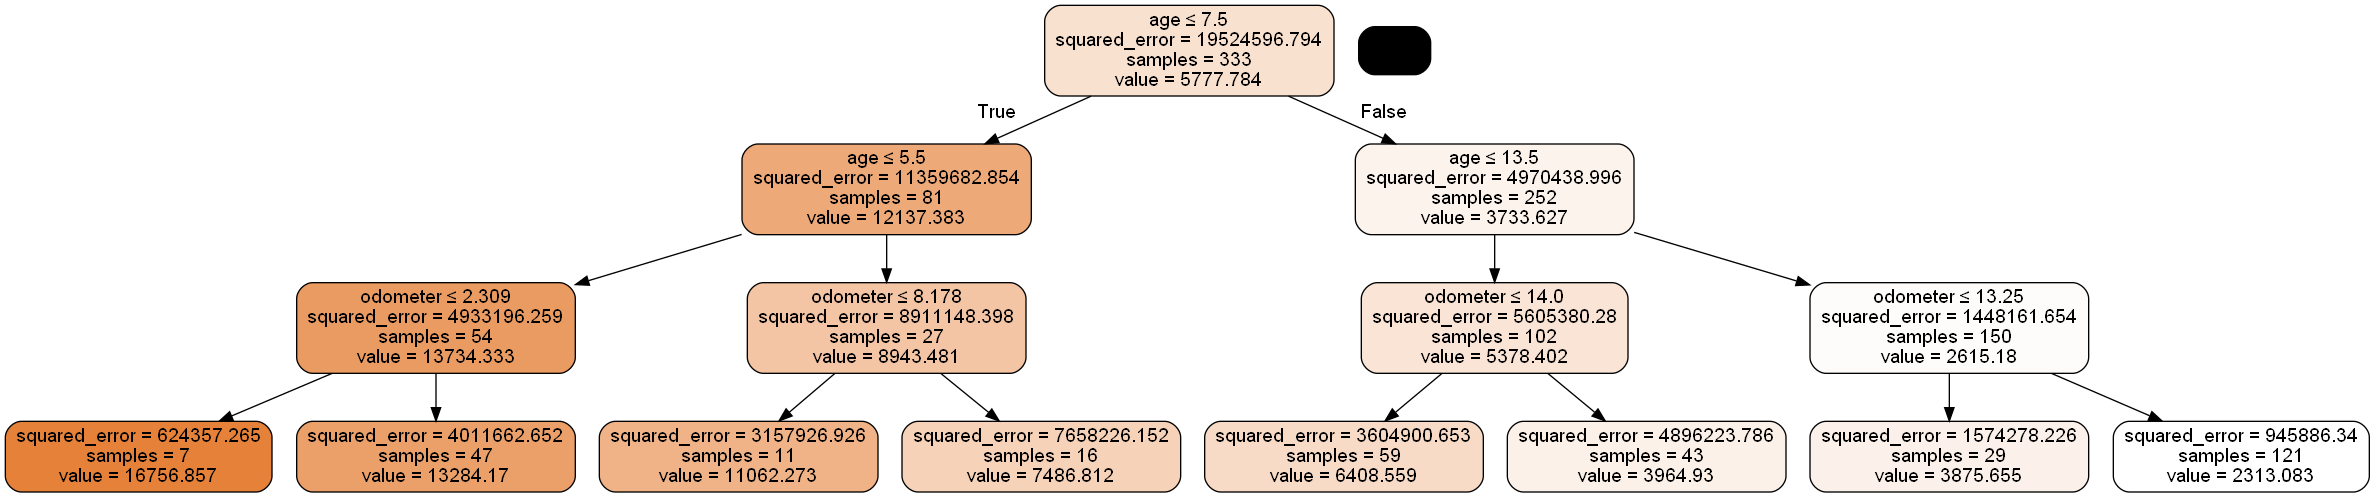

In [81]:
jupyter_graphviz(
    cart4,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=feature_names_model2,
)

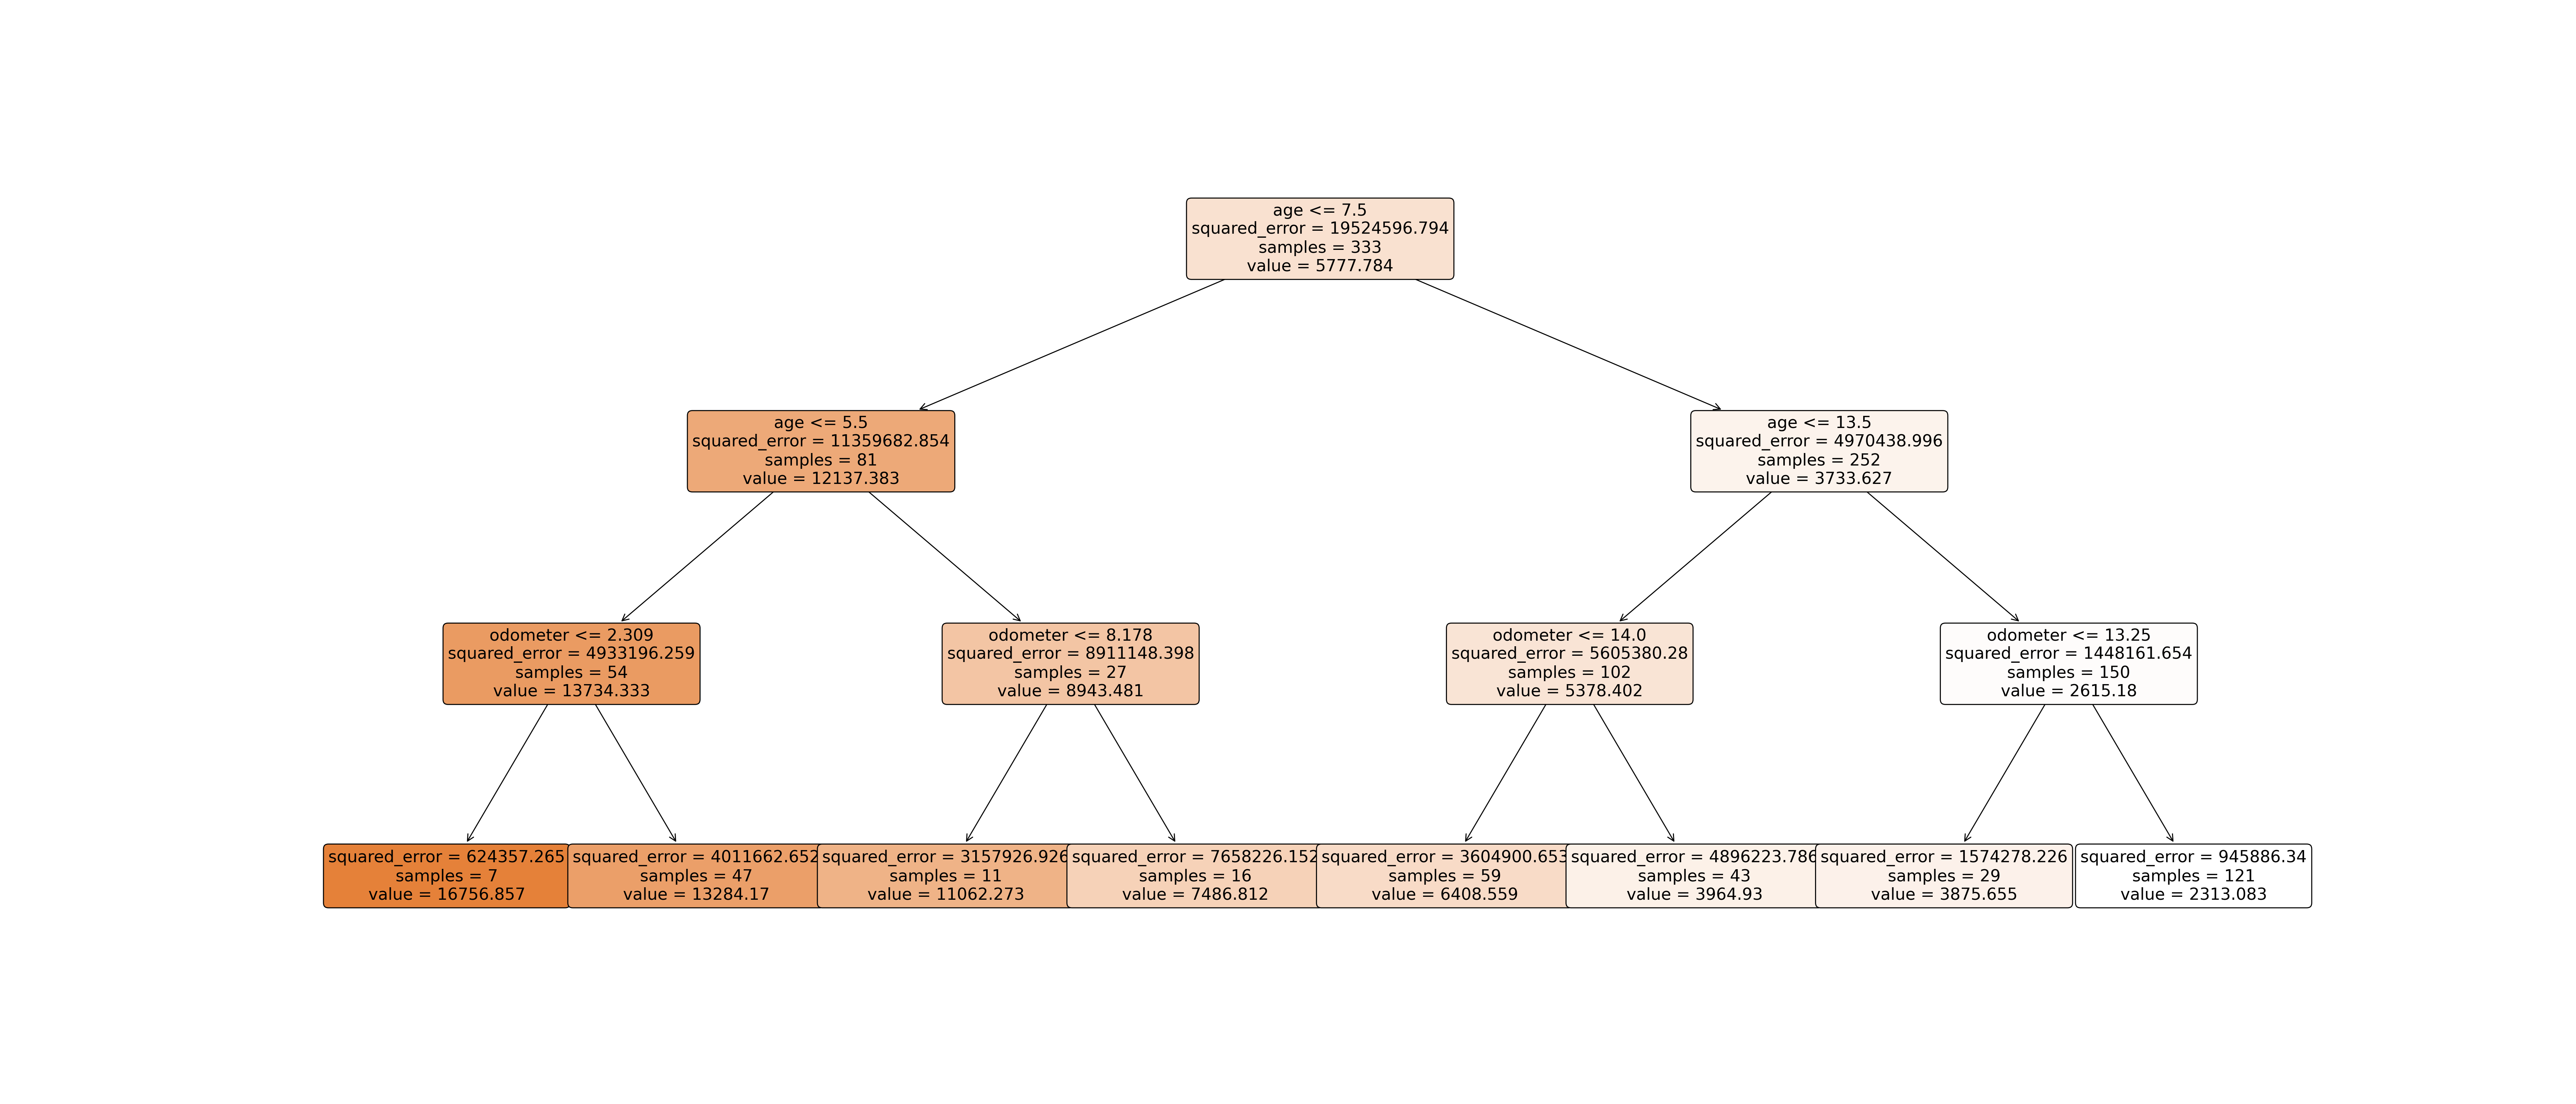

In [82]:
plt.figure(figsize = (35,15))
tree.plot_tree(cart4, filled = True, rounded = True, feature_names= feature_names_model2, fontsize = 16);

**Alternative: using of min_impurity_decrease**

In [83]:
cart4 = DecisionTreeRegressor(
    random_state=20240122,
    criterion="squared_error",
    min_impurity_decrease=145000,
    min_samples_split=20,
)
cart4.fit(X, Y)

y_test, X_test = dmatrices(model2, data_test)

pred_cart4 = cart4.predict(X_test)
rmse_cart4 = np.sqrt(mean_squared_error(y_test, pred_cart4))
rmse_cart4

1776.7208446980017

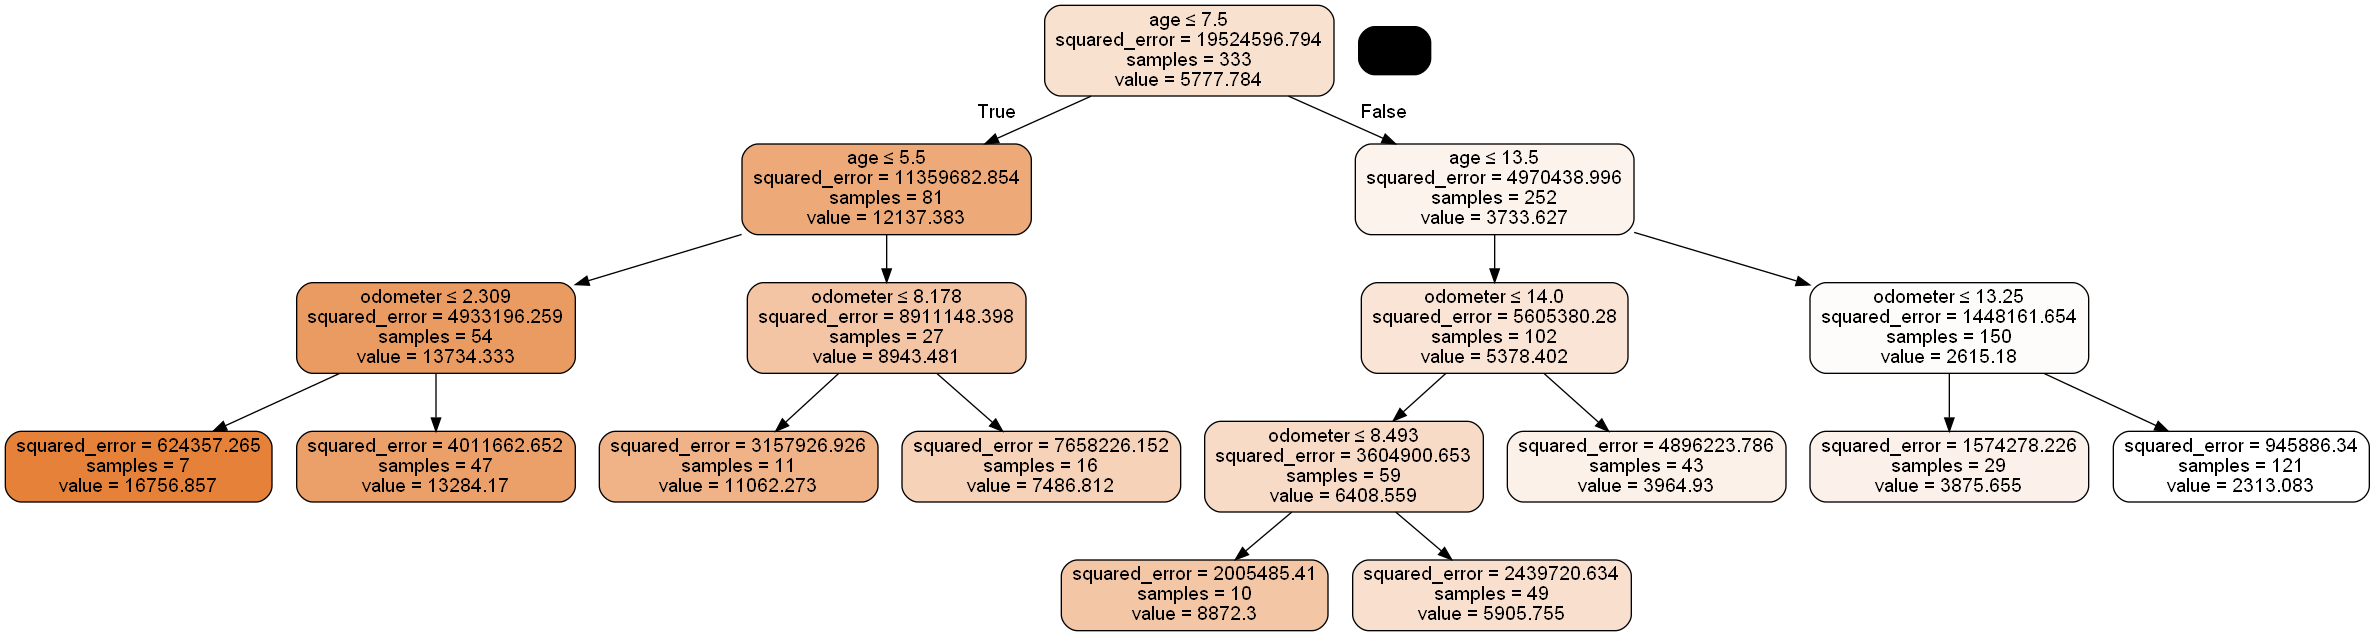

In [84]:
jupyter_graphviz(
    cart4,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=feature_names_model2,
)

In [85]:
cart5 = DecisionTreeRegressor(
    random_state=20240122,
    criterion="squared_error",
    min_impurity_decrease=20000,
)
cart5.fit(X, Y)

DecisionTreeRegressor(min_impurity_decrease=20000, random_state=20240122)

In [86]:
pred_cart5 = cart5.predict(X_test)
rmse_cart5 = np.sqrt(mean_squared_error(y_test, pred_cart5))
rmse_cart5

2125.180782684489

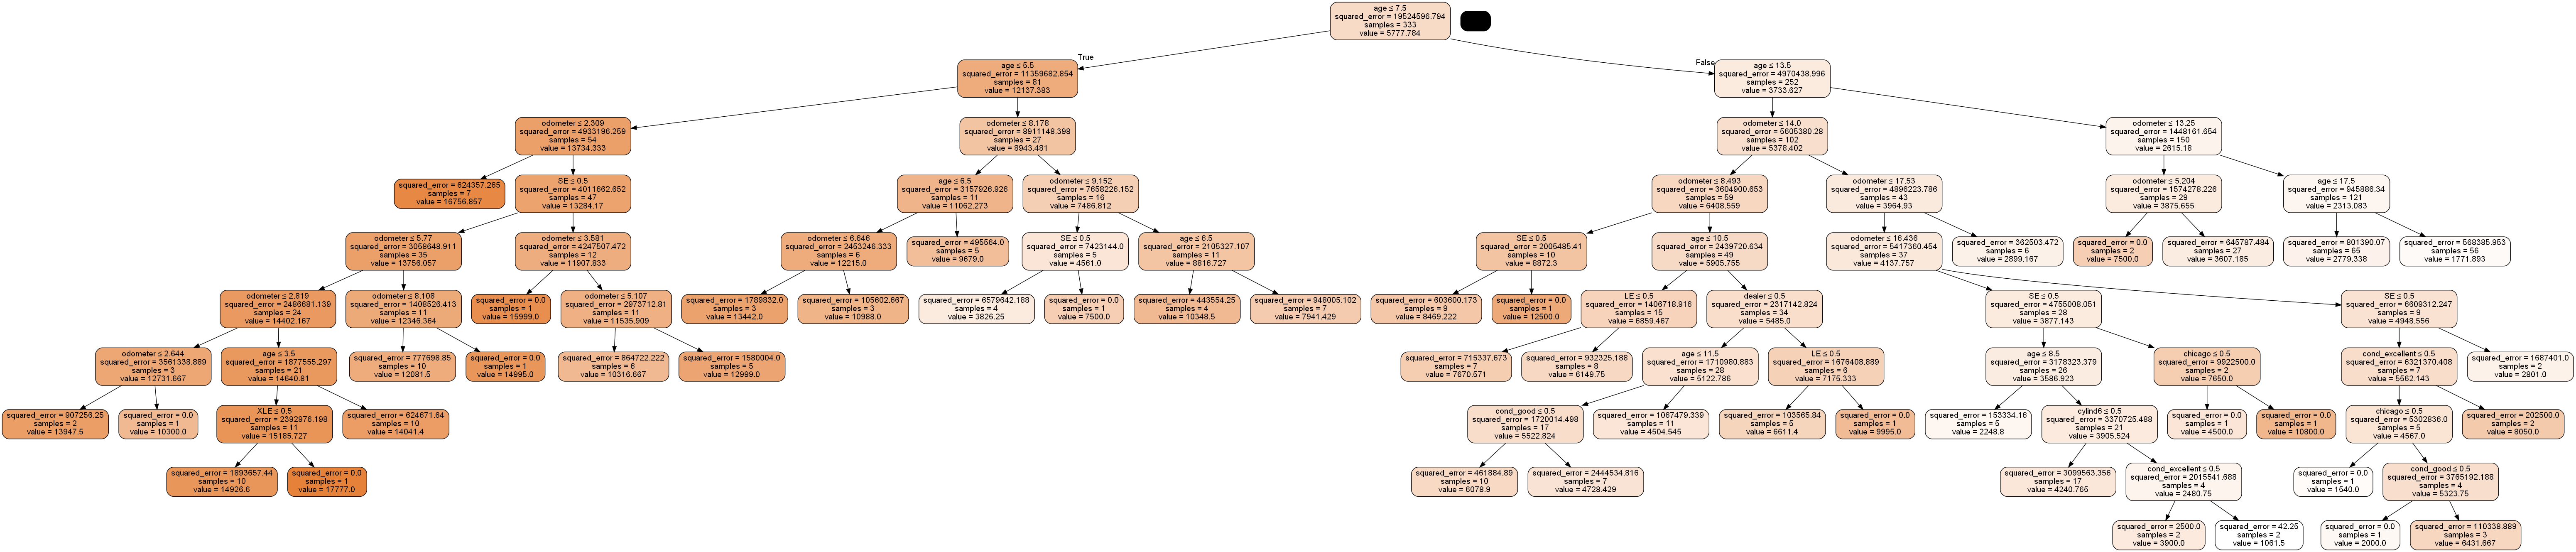

In [87]:
jupyter_graphviz(
    cart5,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=feature_names_model2,
)

**Build very large tree and prune it**

Set the `ccp_alpha` [parameter](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning).

In [88]:
cart6 = DecisionTreeRegressor(
    random_state=20240122, min_samples_split=4, criterion="squared_error",ccp_alpha=30000
)
cart6.fit(X, Y)

DecisionTreeRegressor(ccp_alpha=30000, min_samples_split=4,
                      random_state=20240122)

In [89]:
pred_cart6 = cart6.predict(X_test)
rmse_cart6 = np.sqrt(mean_squared_error(y_test, pred_cart6))
rmse_cart6

2010.940335313178

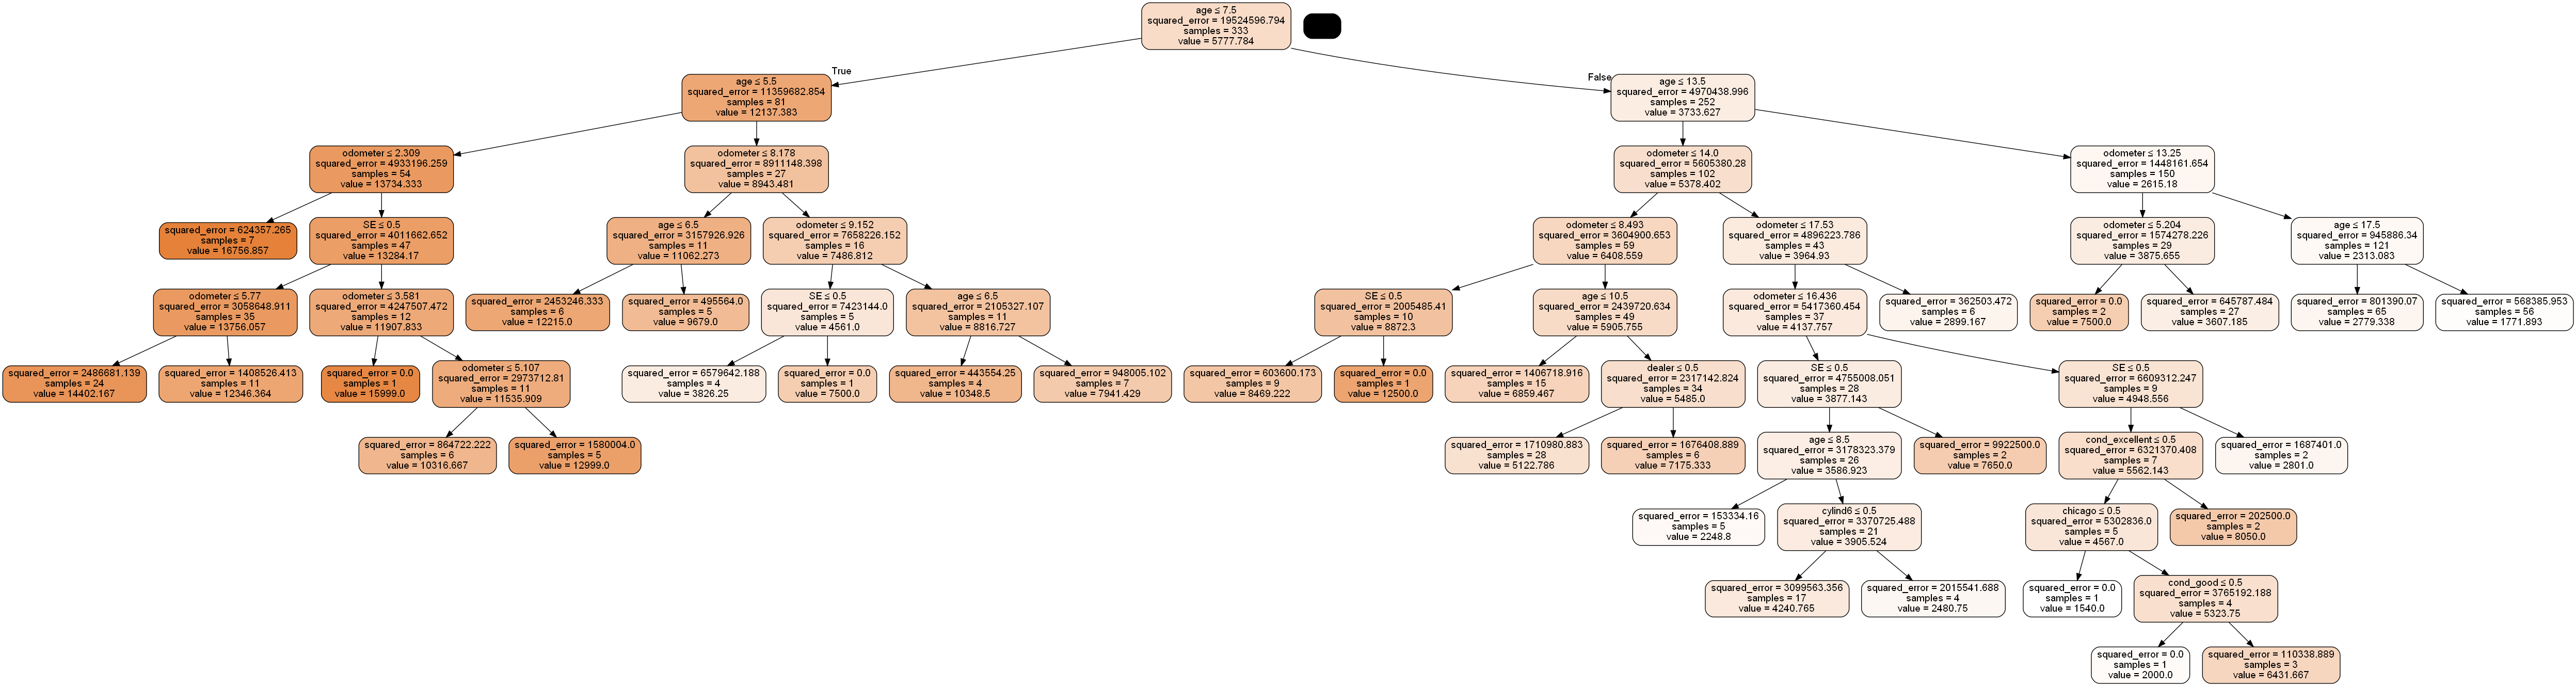

In [90]:
jupyter_graphviz(
    cart6,
    filled=True,
    rounded=True,
    special_characters=True,
    feature_names=feature_names_model2,
)

#### Plot variable importance for model 6

In [91]:
cart6.feature_importances_

array([0.        , 0.87107483, 0.10051707, 0.        , 0.        ,
       0.01618495, 0.0028487 , 0.00242121, 0.00164877, 0.0034218 ,
       0.00188266])

In [92]:
pd.DataFrame(
    {'variable': feature_names_model2, 
     'importance': cart6.feature_importances_}
).sort_values(
        by=["importance"], ascending=False
    ).reset_index(drop = True)

variable  importance
0              age    0.871075
1         odometer    0.100517
2               SE    0.016185
3           dealer    0.003422
4   cond_excellent    0.002849
5        cond_good    0.002421
6          chicago    0.001883
7          cylind6    0.001649
8            price    0.000000
9               LE    0.000000
10             XLE    0.000000

In [93]:
df_cart6_var_imp = (
    pd.DataFrame(
        {'variable': feature_names_model2, 
         'importance': cart6.feature_importances_}
    ).sort_values(
        by=["importance"], ascending=False
    ).reset_index(drop = True)
)

In [94]:
df_cart6_var_imp

variable  importance
0              age    0.871075
1         odometer    0.100517
2               SE    0.016185
3           dealer    0.003422
4   cond_excellent    0.002849
5        cond_good    0.002421
6          chicago    0.001883
7          cylind6    0.001649
8            price    0.000000
9               LE    0.000000
10             XLE    0.000000

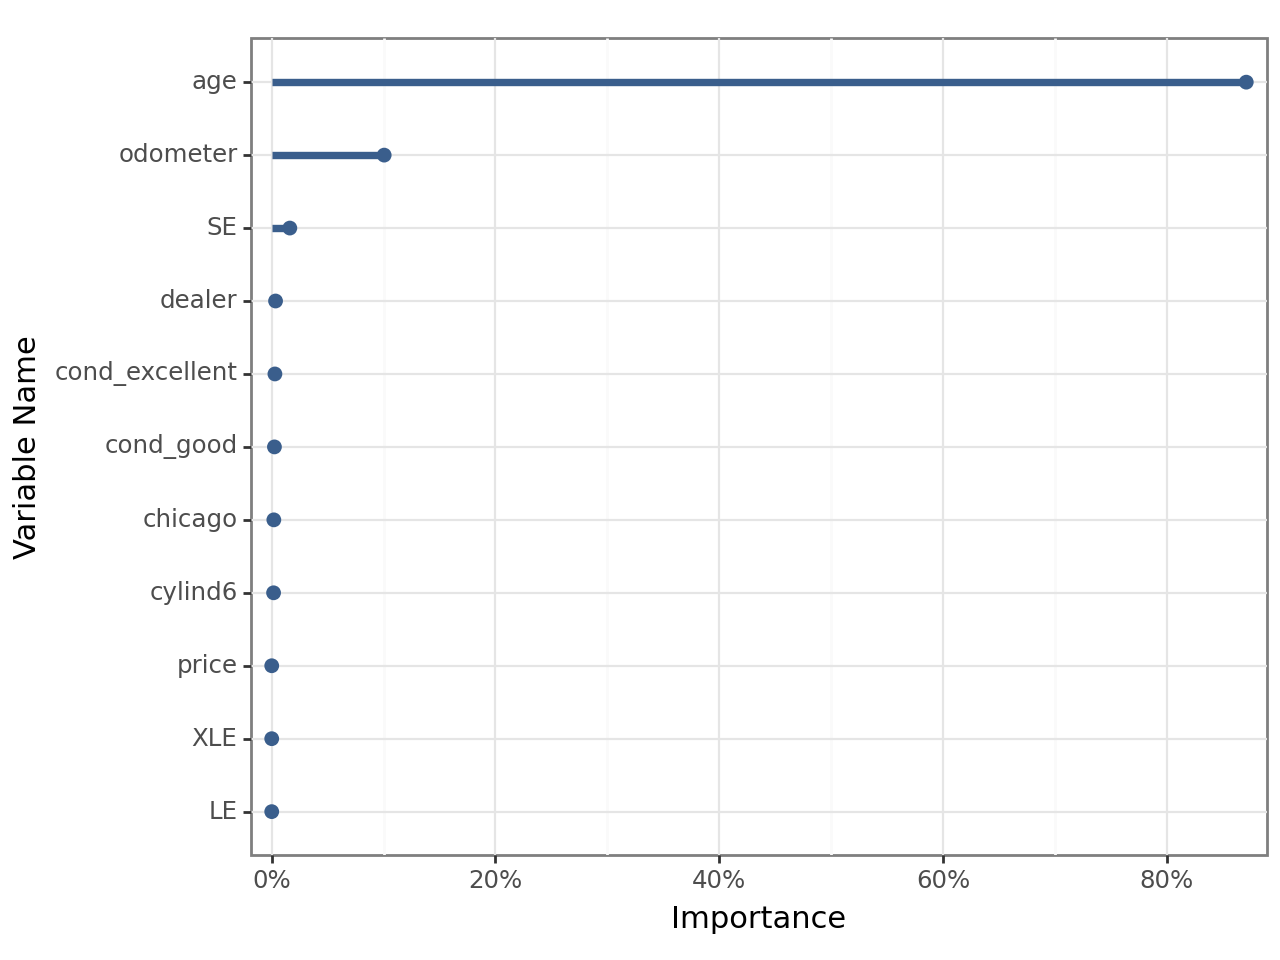

<Figure Size: (640 x 480)>

In [95]:
(
    ggplot(df_cart6_var_imp, aes(x="reorder(variable ,importance)", y="importance"))
    + geom_point(color=color[0], size=2)
    + geom_segment(
        aes(x="variable", xend="variable", y=0, yend="importance"), color=color[0], size=1.5
    )
    + ylab("Importance")
    + xlab("Variable Name")
    + coord_flip()
    + scale_y_continuous(expand=(0.01, 0.01), labels=percent_format())
    + theme_bw()
)

Using Pandas `plot` method.

In [96]:
df_ = df_cart6_var_imp.sort_values(by = 'importance', ascending = True)

In [97]:
df_.importance = df_.importance *100

<Figure size 640x480 with 0 Axes>

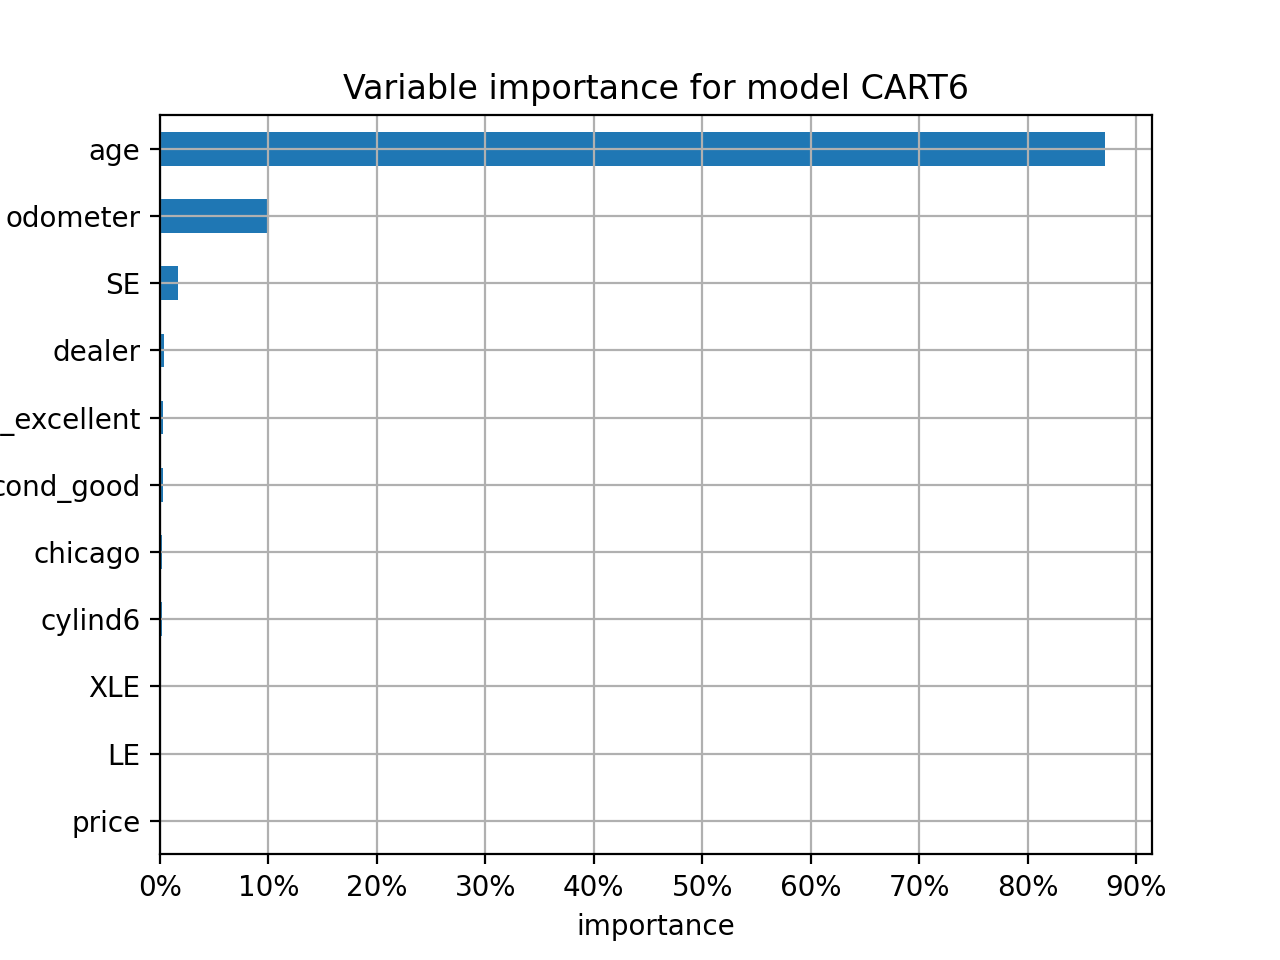

In [98]:
import matplotlib.ticker as mtick

plt.figure()
ax = df_.plot(
    kind = 'barh', x = 'variable', y = 'importance', 
    legend = False, grid = True, 
    xlabel = 'importance', ylabel = 'variable', 
    title = 'Variable importance for model CART6')
ax.set_xticks([x for x in range(0,100, 10)])
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.plot();

In [99]:
pd.DataFrame(
    {
        "Model": ["CART M" + str(i) for i in range(1, 7)]
        + ["OLS M" + str(i) for i in range(1, 4)],
        "Number of variables": [1, 1, 7, 7, 7, 7, 1, 7, 7],
        "Model details": [
            "2 levels",
            "3 levels",
            "min_impurity_decrease=50000",
            "min_impurity_decrease=140000 & min_samples_split=20",
            "min_impurity_decrease=20000",
            "ccp_alpha=30000",
            "linear",
            "linear",
            "w/ polynomial terms",
        ],
        "RMSE": [
            rmse_cart1,
            rmse_cart2,
            rmse_cart3,
            rmse_cart4,
            rmse_cart5,
            rmse_cart6,
            rmse_ols1,
            rmse_linreg2,
            rmse_linreg3,
        ],
    }
).set_index("Model")

Number of variables  \
Model                          
CART M1                    1   
CART M2                    1   
CART M3                    7   
CART M4                    7   
CART M5                    7   
CART M6                    7   
OLS M1                     1   
OLS M2                     7   
OLS M3                     7   

                                             Model details         RMSE  
Model                                                                    
CART M1                                           2 levels  2848.878803  
CART M2                                           3 levels  1999.168573  
CART M3                        min_impurity_decrease=50000  1764.624031  
CART M4  min_impurity_decrease=140000 & min_samples_spl...  1776.720845  
CART M5                        min_impurity_decrease=20000  2125.180783  
CART M6                                    ccp_alpha=30000  2010.940335  
OLS M1                                              linear  2060.681138  
OLS M2                                              linear  1803.250106  
OLS M3                                 w/ polynomial terms  1451.348977